# Re-level ROSETTA-ice gravity data

import the necessary packages

In [ ]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib

import geopandas as gpd
import harmonica as hm
import numpy as np
import pandas as pd
import pooch
import pygmt
import verde as vd
from polartoolkit import maps
from polartoolkit import utils as polar_utils
from tqdm.autonotebook import tqdm

from RIS_gravity_inversion import gravity_processing as RIS_grav

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

logging.getLogger("invert4geom").setLevel("WARN")

from invert4geom import optimization, utils

## load data

In [4]:
path = pooch.retrieve(
    url="http://wonder.ldeo.columbia.edu/data/ROSETTA-Ice/Gravity/rs_2019_grav.csv",
    fname="ROSETTA_2019_grav.csv",
    path=f"{pooch.os_cache('pooch')}/polartoolkit/gravity",
    known_hash="d4fdfcc293ac13e6222938bfa9e1e9ccc781ea7556a13d356e9f1b4aba809928",
    progressbar=True,
)

rosetta = pd.read_csv(path)

# convert line numbers into float format (L200 -> 200)
rosetta.Line = rosetta.Line.str[1:]
rosetta["Line"] = pd.to_numeric(rosetta["Line"])
rosetta.describe()

Line       LATITUDE      LONGITUDE      unixtime  \
count  398279.000000  398279.000000  398279.000000  3.982790e+05   
mean      661.219550     -80.571198     -36.741857  1.457515e+09   
std       264.422153       1.786949     165.241996  1.431469e+07   
min        20.000000     -85.389220    -179.999880  1.447367e+09   
25%       470.000000     -81.869075    -169.885715  1.448316e+09   
50%       650.000000     -80.392556    -158.359371  1.449134e+09   
75%       840.000000     -79.145016     171.037900  1.479949e+09   
max      1140.000000     -77.339971     180.000724  1.480734e+09   

              Height              x             y   FAG_levelled  
count  398279.000000  398279.000000  3.982790e+05  398279.000000  
mean      793.056619  -84278.810943 -1.000705e+06     -40.834964  
std        83.977581  212966.781186  1.984653e+05      14.254793  
min       650.023000 -571781.809097 -1.367767e+06    -326.330214  
25%       744.524000 -240585.860838 -1.160510e+06     -48.199458  
50%       774.652000  -78622.827092 -1.010417e+06     -40.625217  
75%       819.844000   80843.853800 -8.504463e+05     -32.873787  
max      1377.258000  371757.426732 -4.604543e+05      35.356213

line       LATITUDE      LONGITUDE      unixtime  \
count  398279.000000  398279.000000  398279.000000  3.982790e+05   
mean      661.219550     -80.571198     -36.741857  1.457515e+09   
std       264.422153       1.786949     165.241996  1.431469e+07   
min        20.000000     -85.389220    -179.999880  1.447367e+09   
25%       470.000000     -81.869075    -169.885715  1.448316e+09   
50%       650.000000     -80.392556    -158.359371  1.449134e+09   
75%       840.000000     -79.145016     171.037900  1.479949e+09   
max      1140.000000     -77.339971     180.000724  1.480734e+09   

              Height        easting      northing   FAG_levelled  
count  398279.000000  398279.000000  3.982790e+05  398279.000000  
mean      793.056619  -84278.810943 -1.000705e+06     -40.834964  
std        83.977581  212966.781186  1.984653e+05      14.254793  
min       650.023000 -571781.809097 -1.367767e+06    -326.330214  
25%       744.524000 -240585.860838 -1.160510e+06     -48.199458  
50%       774.652000  -78622.827092 -1.010417e+06     -40.625217  
75%       819.844000   80843.853800 -8.504463e+05     -32.873787  
max      1377.258000  371757.426732 -4.604543e+05      35.356213

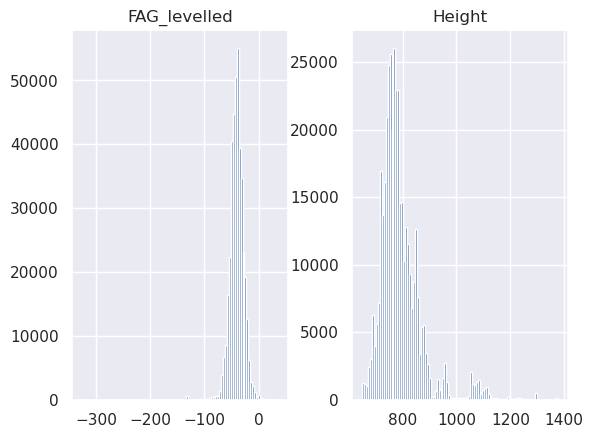

In [5]:
# set standard column names
rosetta = rosetta.rename(columns={"Line": "line", "x": "easting", "y": "northing"})

rosetta = gpd.GeoDataFrame(
    rosetta,
    geometry=gpd.points_from_xy(x=rosetta.easting, y=rosetta.northing),
    crs="EPSG:3031",
)

rosetta[["FAG_levelled", "Height"]].hist(bins=100)
rosetta.describe()

In [4]:
# separate e-w flight lines from n-s tie lines
ties = rosetta[rosetta.line >= 1000]
lines = rosetta[rosetta.line < 1000]

Plot as point data

In [ ]:
# get bounding region of data
# region = vd.get_region((rosetta.x, rosetta.y))
# # zoom out by 20 km
# region = utils.alter_region(region, zoom=-40e3)[0]

region = (-620000.0, 460000.0, -1460000.0, -380000.0)

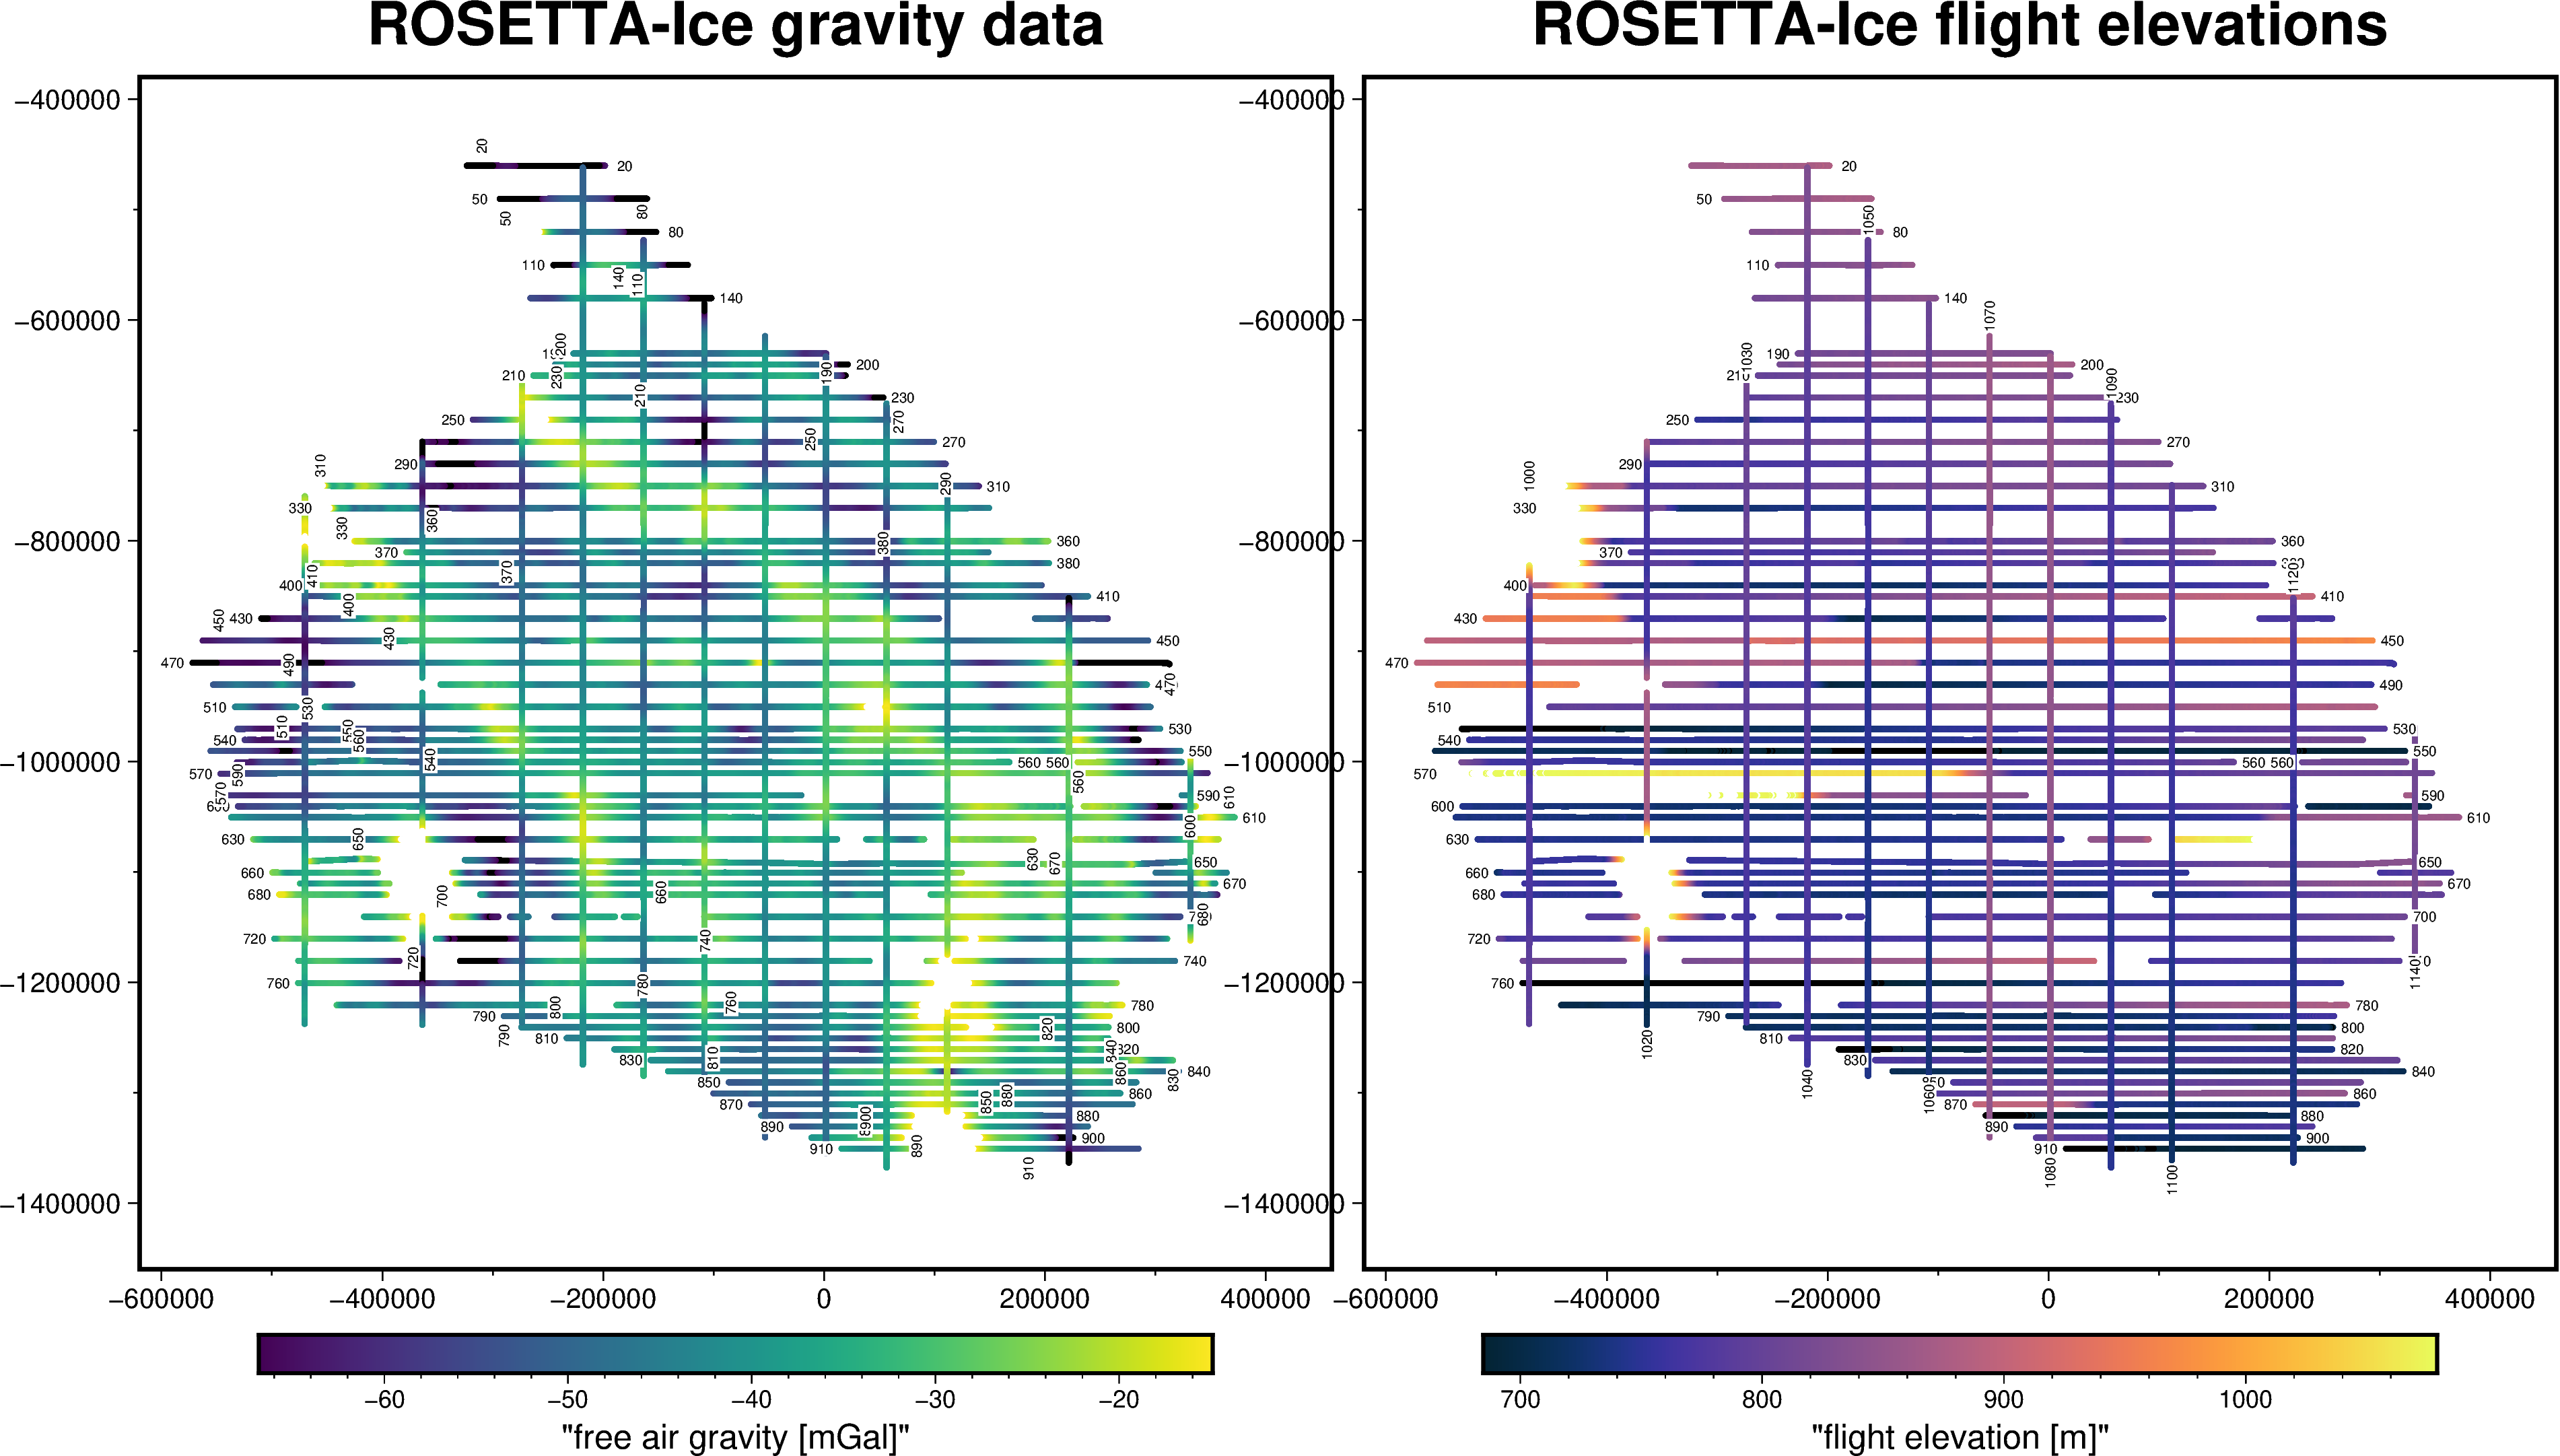

In [6]:
# plot a basemap
fig = maps.basemap(
    region,
    title="ROSETTA-Ice gravity data",
    background="black",
    frame=True,
)

# get a quarter of max absolute value and make a colorscale
pygmt.makecpt(
    cmap="viridis",
    series=polar_utils.get_min_max(rosetta.FAG_levelled, robust=True),
)

# plot gravity data
fig.plot(
    x=rosetta.easting,
    y=rosetta.northing,
    fill=rosetta.FAG_levelled,
    style="c2p",
    cmap=True,
)

RIS_grav.plot_flightlines(fig, lines, plot_lines=False, direction="EW")

RIS_grav.plot_flightlines(fig, lines, plot_lines=False, direction="NS")

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')

# add a second figure to the right
fig = maps.basemap(
    region,
    title="ROSETTA-Ice flight elevations",
    origin_shift="xshift",
    fig=fig,
    background="black",
    frame=True,
)

# make a colorscale for flight elevations
pygmt.makecpt(
    cmap="thermal",
    series=polar_utils.get_min_max(rosetta.Height, robust=True),
)

# plot flight elevation data
fig.plot(
    x=rosetta.easting,
    y=rosetta.northing,
    fill=rosetta.Height,
    style="c2p",
    cmap=True,
)

RIS_grav.plot_flightlines(fig, lines, plot_lines=False, direction="EW")
RIS_grav.plot_flightlines(fig, ties, plot_lines=False, direction="NS")

# plot the colorbar
fig.colorbar(frame='af+l"flight elevation [m]"')

fig.show()

# Intersections
create an intersections dataframe between all lines

In [7]:
# !!! ONLY MAKES INTERSECTION WITHIN LINE, IF REAL INT IS JUST OUTSIDE END OF LINE
# IT WON'T COUNT. SHOULD BUFFER LINES BY DISTANCE.

# buffer dist extends line ends to include crossovers, in this case, T1040 would intersect with
# L20 if it were just 2 km longer.
inters = RIS_grav.create_intersection_table(
    rosetta,
    # cutoff_dist=20e3,
    plot=True,
    exclude_ints=[
        # [470, 1070],
        # [1120], # exclude all of 1120 since its causing issues
    ],
)
inters.describe()

line1        line2       max_dist        easting      northing
count  440.000000   440.000000     440.000000     440.000000  4.400000e+02
mean   568.434091  1065.386364    1401.275955  -82604.363998 -1.008948e+06
std    194.709065    32.438283    9866.763805  184954.802318  1.947669e+05
min     50.000000  1000.000000       1.085047 -470283.712183 -1.350705e+06
25%    425.000000  1040.000000      25.281116 -218371.543409 -1.160520e+06
50%    580.000000  1070.000000      34.630586  -53408.673096 -1.020531e+06
75%    720.000000  1090.000000      42.561628   56631.718071 -8.654540e+05
max    910.000000  1140.000000  132222.764355  331840.937091 -4.903223e+05

In [8]:
# add empty rows at each intersection to the grav df
rosetta, inters = RIS_grav.add_intersections(rosetta, inters)
rosetta[rosetta.is_intersection]

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/geopandas/array.py:1470: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Antarctic Polar Stereographic (the single non-null crs provided).



line  LATITUDE  LONGITUDE  unixtime  Height        easting  \
2234      50.0       NaN        NaN       NaN     NaN -218366.620807   
3614      80.0       NaN        NaN       NaN     NaN -218370.298672   
4467     110.0       NaN        NaN       NaN     NaN -218370.463581   
5011     110.0       NaN        NaN       NaN     NaN -163372.861101   
6158     140.0       NaN        NaN       NaN     NaN -163395.215124   
...        ...       ...        ...       ...     ...            ...   
397731  1140.0       NaN        NaN       NaN     NaN  331826.687432   
398060  1140.0       NaN        NaN       NaN     NaN  331826.259411   
398277  1140.0       NaN        NaN       NaN     NaN  331840.937091   
398388  1140.0       NaN        NaN       NaN     NaN  331832.763929   
398718  1140.0       NaN        NaN       NaN     NaN  331789.980110   

            northing  FAG_levelled                         geometry  \
2234   -4.903223e+05           NaN  POINT (-218366.621 -490322.266)   
3614   -5.204792e+05           NaN  POINT (-218370.299 -520479.220)   
4467   -5.503800e+05           NaN  POINT (-218370.464 -550380.002)   
5011   -5.504074e+05           NaN  POINT (-163372.861 -550407.441)   
6158   -5.804055e+05           NaN  POINT (-163395.215 -580405.511)   
...              ...           ...                              ...   
397731 -1.100608e+06           NaN  POINT (331826.687 -1100607.570)   
398060 -1.070505e+06           NaN  POINT (331826.259 -1070504.518)   
398277 -1.050564e+06           NaN  POINT (331840.937 -1050563.819)   
398388 -1.040655e+06           NaN  POINT (331832.764 -1040655.063)   
398718 -1.010405e+06           NaN  POINT (331789.980 -1010404.823)   

        is_intersection intersecting_line  dist_along_line  
2234               True            1040.0     75298.725128  
3614               True            1040.0     66357.166666  
4467               True            1040.0     26674.343360  
5011               True            1050.0     81671.935836  
6158               True            1050.0     61421.050783  
...                 ...               ...              ...  
397731             True             660.0     74254.443110  
398060             True             630.0    104357.487900  
398277             True             610.0    124298.192629  
398388             True             600.0    134206.942814  
398718             True             570.0    164457.167883  

[880 rows x 12 columns]

In [9]:
inters.sort_values(by=["line1", "line2"])

geometry  line1   line2   max_dist        easting  \
0    POINT (-218366.621 -490322.266)   50.0  1040.0  36.094627 -218366.620807   
1    POINT (-218370.299 -520479.220)   80.0  1040.0  40.828308 -218370.298672   
2    POINT (-218370.464 -550380.002)  110.0  1040.0  36.542176 -218370.463581   
3    POINT (-163372.861 -550407.441)  110.0  1050.0  26.504606 -163372.861101   
4    POINT (-218372.911 -580410.496)  140.0  1040.0  22.845900 -218372.911205   
..                               ...    ...     ...        ...            ...   
435  POINT (111630.697 -1340632.765)  900.0  1100.0  20.145595  111630.697151   
436  POINT (221717.581 -1340638.600)  900.0  1120.0  43.162037  221717.580801   
437   POINT (56714.623 -1350705.460)  910.0  1090.0  38.771702   56714.623014   
438  POINT (111651.805 -1350666.323)  910.0  1100.0  34.282318  111651.804935   
439  POINT (221725.711 -1350630.631)  910.0  1120.0  42.597968  221725.710905   

         northing  dist_along_line1  dist_along_line2  
0   -4.903223e+05      75298.725128      28239.022330  
1   -5.204792e+05      66357.166666      58395.975851  
2   -5.503800e+05      26674.343360      88296.757131  
3   -5.504074e+05      81671.935836      22642.697747  
4   -5.804105e+05     116398.747036     118327.251046  
..            ...               ...               ...  
435 -1.340633e+06     114207.280202      20520.911715  
436 -1.340639e+06       4120.396398     488765.962690  
437 -1.350705e+06     227987.736669     674921.894773  
438 -1.350666e+06     173050.545018      10487.353108  
439 -1.350631e+06      62976.633828     498757.993348  

[440 rows x 8 columns]

In [ ]:
# RIS_grav.plotly_points(
#     rosetta,
#     # color_col="intersecting_line",
#     color_col="FAG_levelled",
#     hover_cols=["line", "dist_along_line", "unixtime"],
#     robust=True,
#     # point_size=5,
# )

In [ ]:
# x = RIS_grav.interp1d(
#     rosetta[rosetta.line.isin([1000])],
#     to_interp=["FAG_levelled", "Height"],

#     # interp_on=["x","y"],
#     # engine="verde",
#     # method=vd.Spline(),

#     interp_on="dist_along_line",
#     engine="scipy",
#     method="cubic",

#     # plot_line=True,
# )

# # x[x.is_intersection]

In [ ]:
# x = grav.interp1d_windows(
#     rosetta[rosetta.line.isin([1000])],
#     to_interp=["FAG_levelled", "Height"],

#     window_width = 1e3,

#     # interp_on=["x","y"],
#     # engine="verde",
#     # method=vd.Spline(),

#     interp_on="dist_along_line",
#     engine="scipy",
#     method="cubic",

#     # plot_windows=True,
#     # plot_line=True,
# )

# # x[x.is_intersection]

## Interpolate data at intersections

In [12]:
rosetta = RIS_grav.interp1d_all_lines(
    rosetta,
    to_interp=["FAG_levelled", "Height"],
    window_width=5e3,
    # interp_on=["x","y"],
    # engine="verde",
    # method=vd.Spline(),
    interp_on="dist_along_line",
    engine="scipy",
    method="cubic",
    # plot=True,
    # wait_for_input=True,
)

too few points in window for intersection of lines 1100.0 & 430.0, doubling window size to 10.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 20.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 40.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 80.0km
too few points in window for intersection of lines 1100.0 & 430.0, doubling window size to 10.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 20.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 40.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 80.0km
too few points in window for intersection of lines 1020.0 & 490.0, doubling window size to 10.0km
too few points in window for intersection of lines 1020.0 & 490.0, doubling window size to 20.

## Save / load from csv

In [13]:
print(rosetta.crs)
type(rosetta)

EPSG:3031


geopandas.geodataframe.GeoDataFrame

In [14]:
rosetta.to_file("../../data/ROSETTA_data_before_UC.gpkg")
inters.to_file(
    "../../data/ROSETTA_intersections_before_UC.gpkg",
)

In [15]:
rosetta = gpd.GeoDataFrame.from_file("../../data/ROSETTA_data_before_UC.gpkg")
inters = gpd.GeoDataFrame.from_file(
    "../../data/ROSETTA_intersections_before_UC.gpkg",
)
print(rosetta.crs)
type(rosetta)

EPSG:3031


geopandas.geodataframe.GeoDataFrame

## Manually check and clean data
set `plot=True` and `wait_for_input=True` in the above call to the function `grav.interp1d_all_lines`. This will give a plot for each flight line. Manually inspect each one, and add lines with issues to the below cell.

In [16]:
lines_with_no_intersections = [
    20,
    560.0,
]
lines_with_int_issues = [
    250,  # gap at 1030
    430,  # gap at 1100
    470,  # interpolated grav at 1050, 1040, and 1030
    510,  # gap at 1000
    630,  # gap at 1100, 1120
    660,  # gap at 1020
    680,  # gap at 1090 # might be close enough
    700,  # gap at 1020, 1050
    720,  # gap at 1020
    1020,  # gap at 660,
]
intersection_issues = [
    [250, 1300],
    [430, 1100],
    # [470, 1030],
    [470, 1040],
    # [470, 1050],
    [510, 1000],
    [630, 1100],
    [630, 1120],
    [660, 1020],
    [680, 1090],
    [700, 1020],
    [700, 1050],
    [720, 1020],
    [840, 1100],
    [1020, 660],
]

lines_with_elev_issues = [
    590,  # short chunk of data at start
]
lines_with_grav_issues = [
    450,  # flat at both ends
    470,  # flat at start, flat between ints of 1050 and 1030, very negative at start
    590,  # short chunk of data at start
    840,  # low at int with 1100
    870,  # flat at end
    900,  # flat at start
    910,  # flat at start
    1040,  # flat at start
    1070,  # flat at end
    1120,  # very negative at start
    1140,  # very positive at start
]

In [ ]:
# RIS_grav.plotly_points(
#     rosetta,
#     coord_names=["easting", "northing"],
#     color_col="FAG_levelled",
#     hover_cols=["FAG_levelled", "Height", "line"],
#     robust=True,
#     # point_size=5,
# )

In [18]:
# RIS_grav.plot_line_and_crosses(
#     rosetta,
#     line=830,
#     y=["FAG_levelled", "Height"],
#     y_axes=[1, 2],
# )

In [ ]:
# RIS_grav.plot_line_and_crosses(
#     rosetta,
#     line=470,
#     y=["FAG_levelled", "Height"],
#     y_axes=[1, 2],
# )

In [ ]:
# RIS_grav.plot_line_and_crosses(
#     rosetta,
#     line=1120,
#     y=["FAG_levelled", "Height"],
#     y_axes=[1, 2],
# )

In [19]:
df = rosetta.copy()
to_remove = []

# 450: delete flat grav data at start
clean = df.loc[
    (df.line == 450) & ((df.dist_along_line < 6e3) | (df.dist_along_line > 802e3))
]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 470: delete flat grav data at start and anomalously low values and flat data between ints 1030 and 1050
clean = df.loc[
    (df.line == 470)
    & ((df.dist_along_line < 90e3) | (df.dist_along_line.between(476.5e3, 585.5e3)))
]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 590: delete grav + height data at start
clean = df.loc[(df.line == 590) & (df.dist_along_line < 10e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 650: delete grav + height data after Roosevelt Island (too high)
clean = df.loc[(df.line == 650) & (df.dist_along_line > 700e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 830: delete grav + height at beginning (maybe a false anomaly?)
clean = df.loc[(df.line == 830) & (df.dist_along_line < 69e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 840: delete grav low between 228k - 294k at int with 1100
clean = df.loc[(df.line == 840) & (df.dist_along_line.between(228e3, 294e3))]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 870: delete grav + height data at end
clean = df.loc[(df.line == 870) & (df.dist_along_line > 315e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 890: delete grav + height data at start
clean = df.loc[(df.line == 890) & (df.dist_along_line < 13e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 900: delete grav + height data at start
clean = df.loc[(df.line == 900) & (df.dist_along_line < 3.8e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 910: delete grav + height data at start
clean = df.loc[(df.line == 910) & (df.dist_along_line < 26e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 1040: delete grav + height data at start
clean = df.loc[(df.line == 1040) & (df.dist_along_line < 27e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 1070: delete grav + height data at end, removes intersection with 880
clean = df.loc[(df.line == 1070) & (df.dist_along_line > 700e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

df_remove = pd.concat(to_remove)

rosetta_cleaned = rosetta.drop(index=df_remove.index)
assert len(rosetta_cleaned) == len(rosetta) - len(df_remove)

print(f"\ntotal number of rows in dataframe: {len(rosetta_cleaned)}")

removing 624 points from line [450.]
removing 2063 points from line [470.]
removing 70 points from line [590.]
removing 933 points from line [650.]
removing 755 points from line [830.]
removing 712 points from line [840.]
removing 331 points from line [870.]
removing 149 points from line [890.]
removing 40 points from line [900.]
removing 269 points from line [910.]
removing 272 points from line [1040.]
removing 267 points from line [1070.]

total number of rows in dataframe: 392674


In [20]:
print(
    f"number of intersections in dataframe: {len(rosetta_cleaned[rosetta_cleaned.is_intersection])}"
)
print(f"number of intersections: {len(inters)}")

number of intersections in dataframe: 877
number of intersections: 440


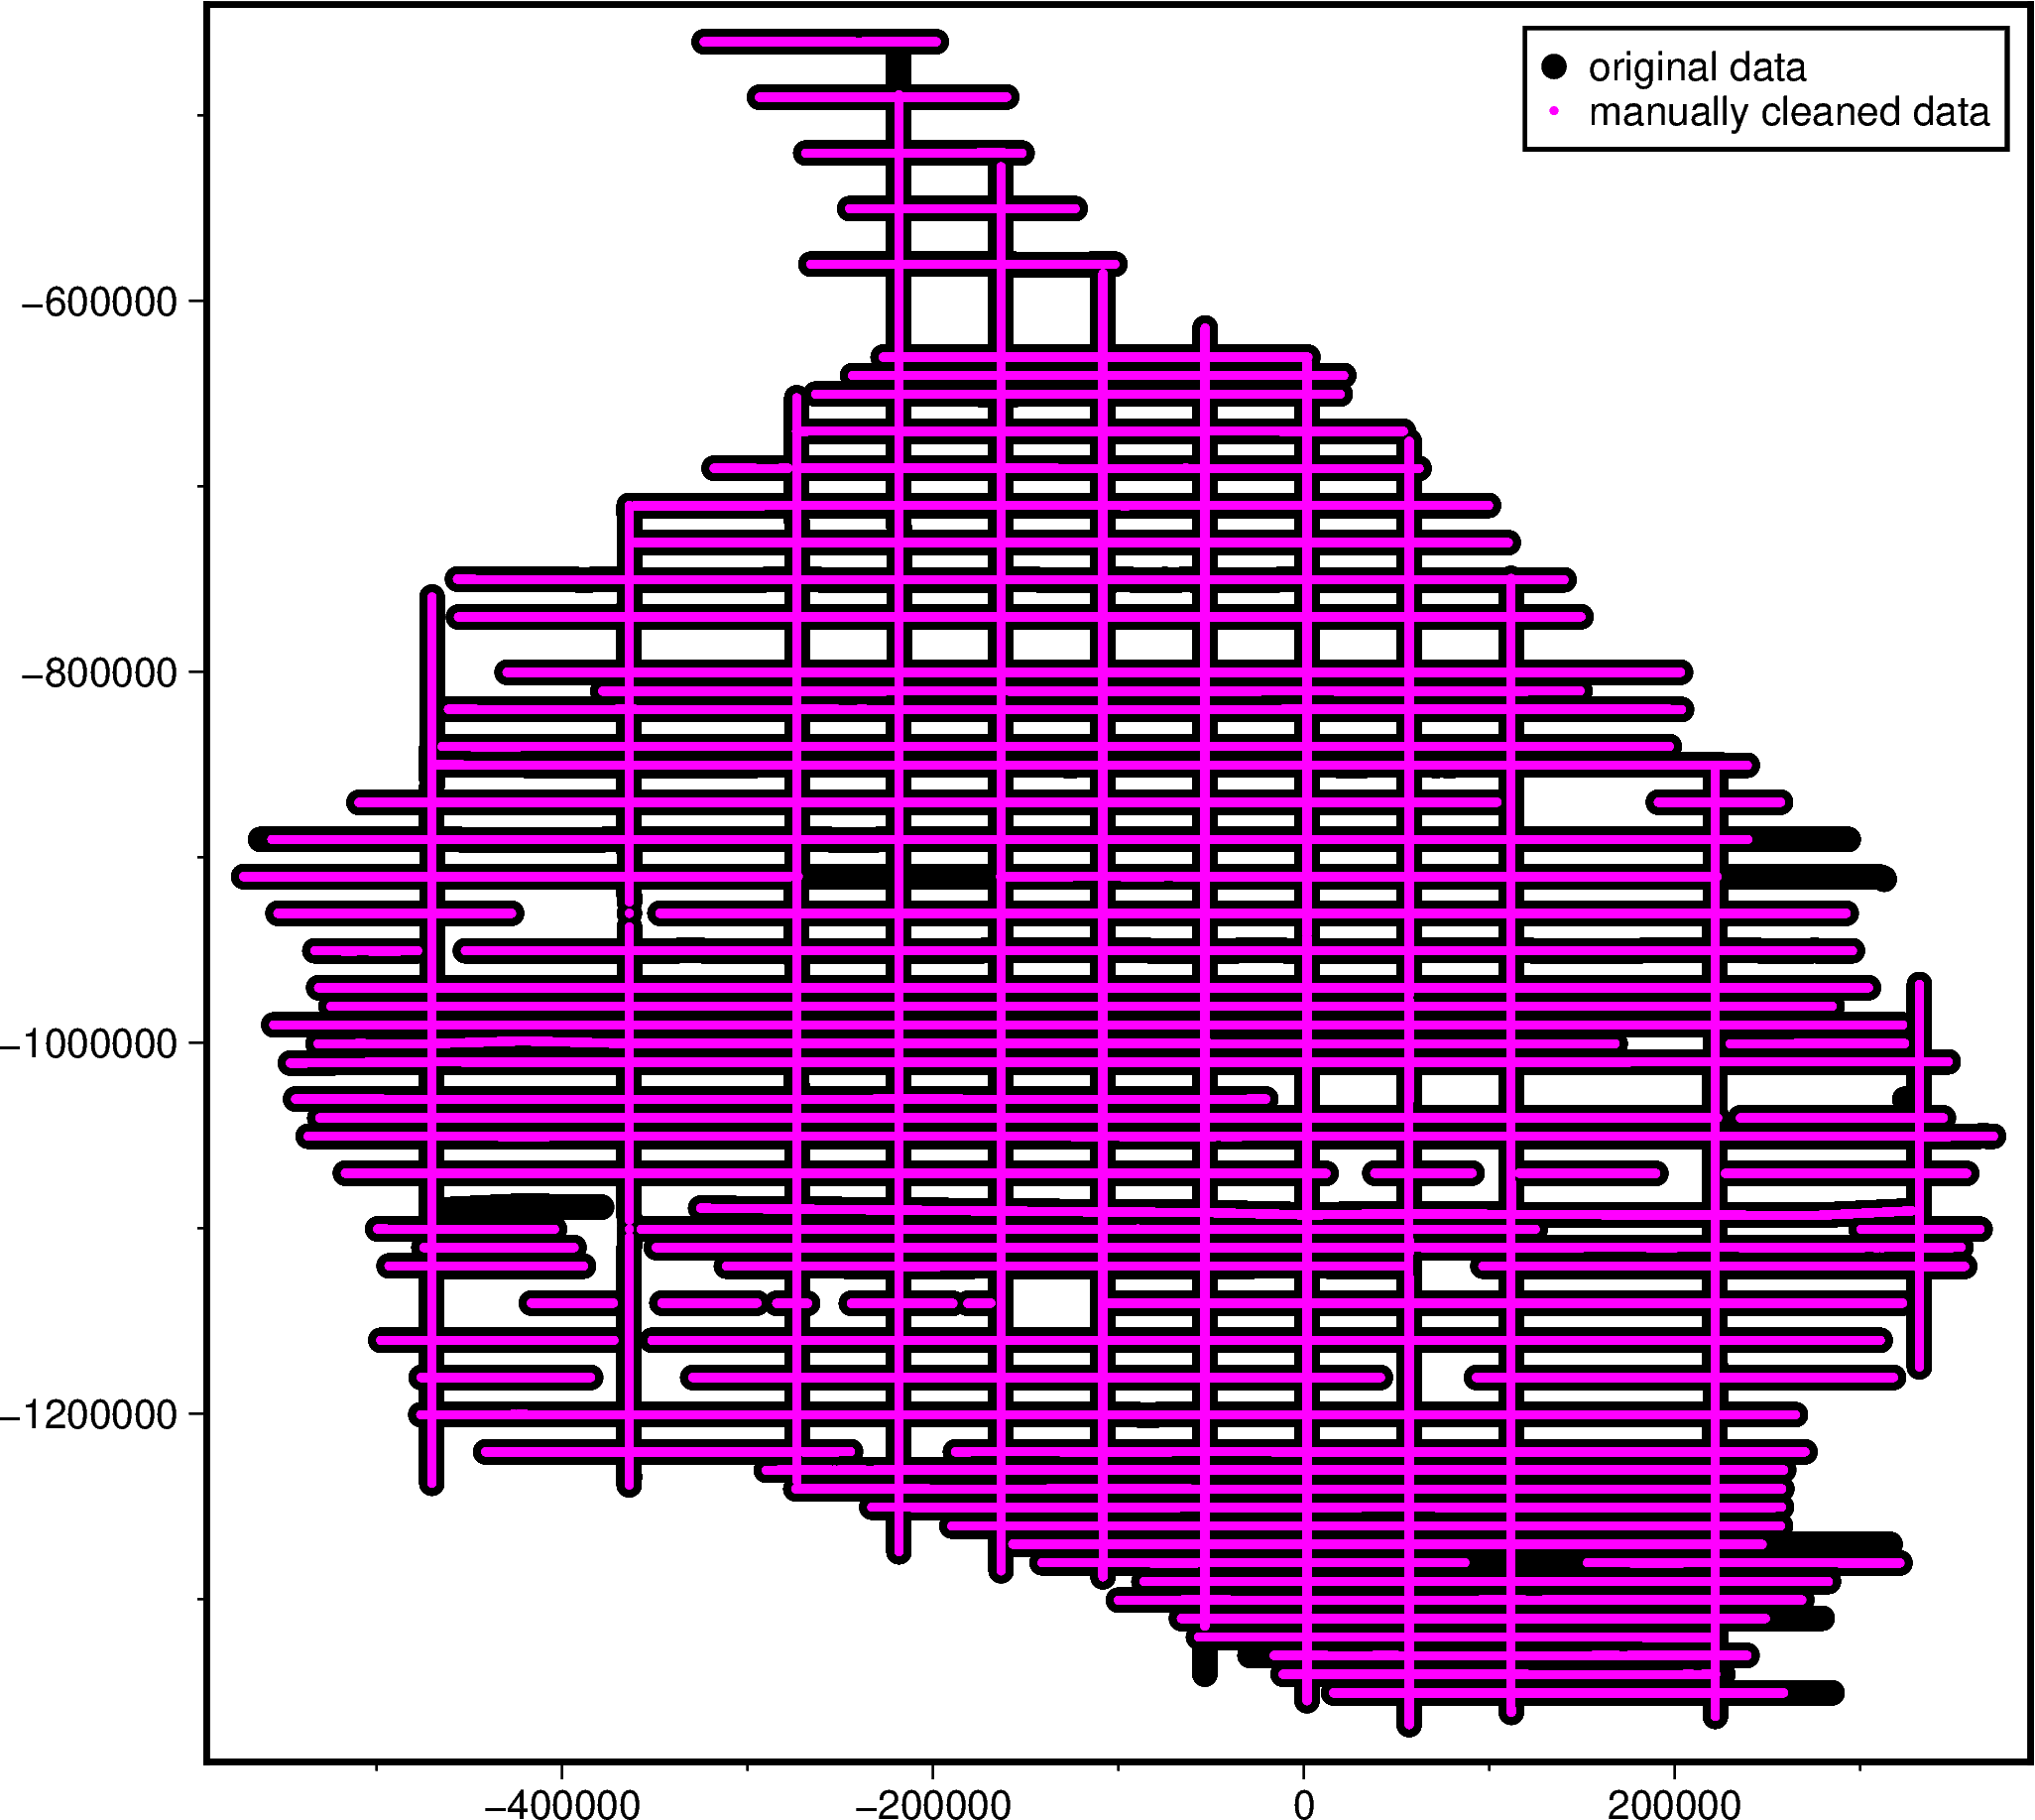

In [21]:
# plot a basemap
fig = maps.basemap(
    region=vd.pad_region(vd.get_region((rosetta.easting, rosetta.northing)), 20e3),
    frame=True,
    # background="black",
)

# plot gravity data
fig.plot(
    x=rosetta.easting,
    y=rosetta.northing,
    style="c6p",
    fill="black",
    label="original data",
)

# plot gravity data
fig.plot(
    x=rosetta_cleaned.easting,
    y=rosetta_cleaned.northing,
    style="c2p",
    fill="magenta",
    label="manually cleaned data",
)

fig.legend()
fig.show()

## Re-do intersections with cleaned data

In [22]:
inters = RIS_grav.create_intersection_table(
    rosetta_cleaned,
    # cutoff_dist=20e3,
    exclude_ints=[
        # [470, 1070],
        # [1120], # exclude all of 1120 since its causing issues
    ],
    plot=False,
)
rosetta_df, inters = RIS_grav.add_intersections(rosetta_cleaned, inters)

print(
    f"number of intersections in dataframe: {len(rosetta_df[rosetta_df.is_intersection])}"
)
print(f"number of intersections: {len(inters)}")

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/geopandas/array.py:1470: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Antarctic Polar Stereographic (the single non-null crs provided).



number of intersections in dataframe: 868
number of intersections: 434


## Re-interpolate at new intersections

In [23]:
rosetta_df = RIS_grav.interp1d_all_lines(
    rosetta_df,
    to_interp=["FAG_levelled", "Height"],
    window_width=5e3,
    interp_on="dist_along_line",
    engine="scipy",
    method="cubic",
    # plot=True,
    # wait_for_input=True,
)
rosetta_df[rosetta_df.is_intersection]

too few points in window for intersection of lines 1100.0 & 430.0, doubling window size to 10.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 20.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 40.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 80.0km
too few points in window for intersection of lines 1100.0 & 430.0, doubling window size to 10.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 20.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 40.0km
bounds error for iterpolation of intersection of lines 1100.0 & 430.0, doubling window size to 80.0km
too few points in window for intersection of lines 1040.0 & 470.0, doubling window size to 10.0km
too few points in window for intersection of lines 1040.0 & 470.0, doubling window size to 20.

line  LATITUDE  LONGITUDE  unixtime      Height        easting  \
2234      50.0       NaN        NaN       NaN  865.944503 -218366.620807   
3614      80.0       NaN        NaN       NaN  841.388347 -218370.298672   
4467     110.0       NaN        NaN       NaN  829.725891 -218370.463581   
5011     110.0       NaN        NaN       NaN  842.392102 -163372.861101   
6158     140.0       NaN        NaN       NaN  835.901104 -163395.215124   
...        ...       ...        ...       ...         ...            ...   
391237  1140.0       NaN        NaN       NaN  817.359125  331826.687432   
391566  1140.0       NaN        NaN       NaN  818.293178  331826.259411   
391783  1140.0       NaN        NaN       NaN  821.552383  331840.937091   
391894  1140.0       NaN        NaN       NaN  819.200242  331832.763929   
392224  1140.0       NaN        NaN       NaN  811.055246  331789.980110   

            northing  FAG_levelled intersecting_line  dist_along_line  \
2234   -4.903223e+05    -50.753657            1040.0     75298.725128   
3614   -5.204792e+05    -47.628501            1040.0     66357.166666   
4467   -5.503800e+05    -47.596844            1040.0     26674.343360   
5011   -5.504074e+05    -39.553608            1050.0     81671.935836   
6158   -5.804055e+05    -36.347866            1050.0     61421.050783   
...              ...           ...               ...              ...   
391237 -1.100608e+06    -41.511223             660.0     74254.443110   
391566 -1.070505e+06    -31.341988             630.0    104357.487900   
391783 -1.050564e+06    -32.080697             610.0    124298.192629   
391894 -1.040655e+06    -33.006908             600.0    134206.942814   
392224 -1.010405e+06    -35.124642             570.0    164457.167883   

                               geometry  is_intersection  
2234    POINT (-218366.621 -490322.266)             True  
3614    POINT (-218370.299 -520479.220)             True  
4467    POINT (-218370.464 -550380.002)             True  
5011    POINT (-163372.861 -550407.441)             True  
6158    POINT (-163395.215 -580405.511)             True  
...                                 ...              ...  
391237  POINT (331826.687 -1100607.570)             True  
391566  POINT (331826.259 -1070504.518)             True  
391783  POINT (331840.937 -1050563.819)             True  
391894  POINT (331832.764 -1040655.063)             True  
392224  POINT (331789.980 -1010404.823)             True  

[868 rows x 12 columns]

##  Get crossover errors

https://gist.github.com/maptastik/dc3d3b4514546310500a13fb77663bb9


In [25]:
inters, rosetta_df = RIS_grav.calculate_misties(
    inters,
    rosetta_df,
    data_col="FAG_levelled",
    mistie_name="mistie_before_UC",
    # plot=True,
    robust=False,
)
print(f"mistie RMS: {utils.rmse(inters.mistie_before_UC)}mGal")
inters.sort_values(by="mistie_before_UC")

mistie RMS: 5.498640739815687mGal


geometry  line1   line2      max_dist  \
430   POINT (221717.581 -1340638.600)  900.0  1120.0     43.162037   
219   POINT (331789.980 -1010404.823)  570.0  1140.0     21.841974   
139      POINT (1628.803 -910521.686)  470.0  1080.0     23.011564   
142    POINT (221728.990 -910507.631)  470.0  1120.0     45.784280   
131    POINT (221715.809 -890495.779)  450.0  1120.0     43.367139   
..                                ...    ...     ...           ...   
282   POINT (221677.772 -1100635.583)  660.0  1120.0  78632.461076   
136   POINT (-163362.655 -910486.904)  470.0  1050.0     19.617624   
273  POINT (-363790.272 -1100571.641)  660.0  1020.0   6336.747330   
319  POINT (-363850.304 -1160540.086)  720.0  1020.0   8205.780808   
285  POINT (-363798.711 -1110480.674)  670.0  1020.0  14482.802887   

           easting      northing  dist_along_line1  dist_along_line2  \
430  221717.580801 -1.340639e+06        298.011709     488765.962690   
219  331789.980110 -1.010405e+06     878331.819658     164457.167883   
139    1628.803221 -9.105217e+05     221124.697059     444319.097936   
142  221728.989944 -9.105076e+05       1024.510116      58634.994370   
131  221715.809338 -8.904958e+05     778264.612225      38623.149362   
..             ...           ...               ...               ...   
282  221677.772118 -1.100636e+06     721241.396509     248762.953741   
136 -163362.654711 -9.104869e+05     386116.155173     382722.160311   
273 -363790.272244 -1.100572e+06     135773.348656     390191.972721   
319 -363850.303716 -1.160540e+06     674573.403638     450160.417779   
285 -363798.710674 -1.110481e+06     110778.679854     400101.005115   

     line1_value  line2_value  mistie_before_UC  
430   -89.901565   -57.828465        -32.073100  
219   -51.912501   -35.124642        -16.787859  
139   -43.190778   -30.585586        -12.605192  
142   -39.158067   -26.682315        -12.475752  
131   -45.324546   -34.409350        -10.915196  
..           ...          ...               ...  
282    -8.753910   -30.950001         22.196091  
136   -23.743761   -48.566815         24.823055  
273    24.459975    -1.393981         25.853956  
319     2.451403   -38.117798         40.569202  
285    36.478854    -6.957361         43.436215  

[434 rows x 11 columns]

## Save / load from csv

In [26]:
rosetta_df.to_csv(
    "../../data/ROSETTA_cleaned.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
inters.to_file(
    "../../data/ROSETTA_cleaned_intersections.gpkg",
)

In [27]:
rosetta_df = pd.read_csv(
    "../../data/ROSETTA_cleaned.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inters = gpd.GeoDataFrame.from_file(
    "../../data/ROSETTA_cleaned_intersections.gpkg",
)
rosetta_df.describe()

line       LATITUDE      LONGITUDE      unixtime  \
count  392665.000000  391797.000000  391797.000000  3.917970e+05   
mean      661.296327     -80.582793     -37.731744  1.457218e+09   
std       265.439146       1.782601     165.071979  1.416613e+07   
min        20.000000     -85.389220    -179.999880  1.447367e+09   
25%       470.000000     -81.902383    -170.004771  1.448316e+09   
50%       630.000000     -80.396924    -158.495897  1.449131e+09   
75%       850.000000     -79.159686     171.146777  1.479947e+09   
max      1140.000000     -77.339971     180.000724  1.480734e+09   

              Height        easting      northing   FAG_levelled  \
count  392665.000000  392665.000000  3.926650e+05  392665.000000   
mean      792.718891  -86003.867050 -9.996115e+05     -40.674264   
std        83.863497  211336.255947  1.979675e+05      13.662769   
min       650.023000 -571781.809097 -1.367767e+06    -326.330214   
25%       744.443000 -241141.189235 -1.160505e+06     -48.113560   
50%       774.601000  -80354.532432 -1.010413e+06     -40.610241   
75%       819.289000   76185.914486 -8.504349e+05     -32.887337   
max      1377.258000  371757.426732 -4.604543e+05      36.478854   

       intersecting_line  dist_along_line  mistie_before_UC  
count         868.000000    392665.000000        868.000000  
mean          816.256912    326695.387544          0.666057  
std           285.718138    220283.512547          5.461298  
min            50.000000         0.000000        -32.073100  
25%           570.000000    139264.894847         -1.754538  
50%           955.000000    297922.751583          0.254597  
75%          1070.000000    489554.898121          1.945501  
max          1140.000000    908716.753527         43.436215

In [28]:
from scipy import stats

stats.percentileofscore(rosetta_df.Height, 1000)

96.29149529497154

<Axes: ylabel='Frequency'>

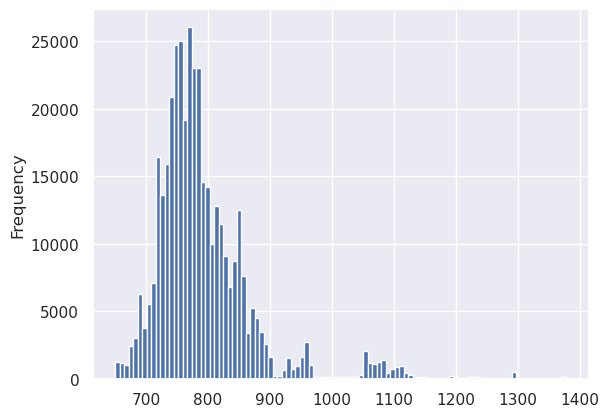

In [29]:
rosetta_df.Height.plot.hist(bins=100)

<Axes: ylabel='Frequency'>

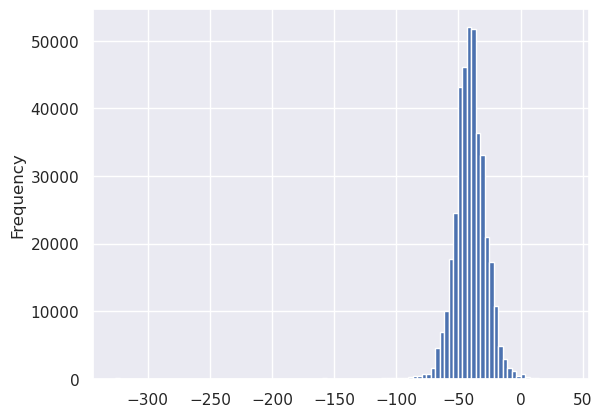

In [30]:
rosetta_df.FAG_levelled.plot.hist(bins=100)

# Individually block-reduce lines

In [32]:
grouped = rosetta_df.groupby("line")

blocked_dfs = []
for name, group in grouped:
    df = group.drop(columns="geometry")

    blocked = polar_utils.block_reduce(
        df.drop(columns=["is_intersection", "intersecting_line"]),
        np.mean,
        spacing=1e3,
        center_coordinates=False,
        input_coord_names=["easting", "northing"],
    )

    # add back columns
    blocked["is_intersection"] = False
    blocked["intersecting_line"] = ""

    # merge back intersection points
    prior_len = len(blocked)
    blocked = pd.concat([blocked, df[df.is_intersection]])
    assert len(blocked) == prior_len + len(df[df.is_intersection])

    blocked_dfs.append(blocked)

rosetta_blocked = pd.concat(blocked_dfs)
rosetta_blocked

easting      northing    line   LATITUDE   LONGITUDE  \
0      -323017.301127 -4.604725e+05    20.0 -84.827798 -144.950697   
1      -321997.009961 -4.604783e+05    20.0 -84.833130 -145.036205   
2      -320976.263358 -4.604806e+05    20.0 -84.838479 -145.121727   
3      -319954.356535 -4.604793e+05    20.0 -84.843849 -145.207317   
4      -318974.502480 -4.604769e+05    20.0 -84.848997 -145.289477   
...               ...           ...     ...        ...         ...   
391237  331826.687432 -1.100608e+06  1140.0        NaN         NaN   
391566  331826.259411 -1.070505e+06  1140.0        NaN         NaN   
391783  331840.937091 -1.050564e+06  1140.0        NaN         NaN   
391894  331832.763929 -1.040655e+06  1140.0        NaN         NaN   
392224  331789.980110 -1.010405e+06  1140.0        NaN         NaN   

            unixtime      Height  FAG_levelled  dist_along_line  \
0       1.480724e+09  864.253917    -79.585185    124715.592483   
1       1.480724e+09  863.984667    -79.477289    123695.301723   
2       1.480724e+09  864.379083    -79.280965    122674.555360   
3       1.480724e+09  864.349250    -79.010975    121652.648406   
4       1.480724e+09  864.732182    -78.693828    120672.794120   
...              ...         ...           ...              ...   
391237           NaN  817.359125    -41.511223     74254.443110   
391566           NaN  818.293178    -31.341988    104357.487900   
391783           NaN  821.552383    -32.080697    124298.192629   
391894           NaN  819.200242    -33.006908    134206.942814   
392224           NaN  811.055246    -35.124642    164457.167883   

        mistie_before_UC  is_intersection intersecting_line  
0                    NaN            False                    
1                    NaN            False                    
2                    NaN            False                    
3                    NaN            False                    
4                    NaN            False                    
...                  ...              ...               ...  
391237          5.295003             True             660.0  
391566          1.763079             True             630.0  
391783          1.681957             True             610.0  
391894          4.427681             True             600.0  
392224        -16.787859             True             570.0  

[37832 rows x 12 columns]

In [33]:
rosetta_blocked[rosetta_blocked.is_intersection]

easting      northing    line  LATITUDE  LONGITUDE  unixtime  \
2234   -218366.620807 -4.903223e+05    50.0       NaN        NaN       NaN   
3614   -218370.298672 -5.204792e+05    80.0       NaN        NaN       NaN   
4467   -218370.463581 -5.503800e+05   110.0       NaN        NaN       NaN   
5011   -163372.861101 -5.504074e+05   110.0       NaN        NaN       NaN   
6158   -163395.215124 -5.804055e+05   140.0       NaN        NaN       NaN   
...               ...           ...     ...       ...        ...       ...   
391237  331826.687432 -1.100608e+06  1140.0       NaN        NaN       NaN   
391566  331826.259411 -1.070505e+06  1140.0       NaN        NaN       NaN   
391783  331840.937091 -1.050564e+06  1140.0       NaN        NaN       NaN   
391894  331832.763929 -1.040655e+06  1140.0       NaN        NaN       NaN   
392224  331789.980110 -1.010405e+06  1140.0       NaN        NaN       NaN   

            Height  FAG_levelled  dist_along_line  mistie_before_UC  \
2234    865.944503    -50.753657     75298.725128          0.000089   
3614    841.388347    -47.628501     66357.166666          0.000014   
4467    829.725891    -47.596844     26674.343360         -6.170917   
5011    842.392102    -39.553608     81671.935836          6.171114   
6158    835.901104    -36.347866     61421.050783         -0.340491   
...            ...           ...              ...               ...   
391237  817.359125    -41.511223     74254.443110          5.295003   
391566  818.293178    -31.341988    104357.487900          1.763079   
391783  821.552383    -32.080697    124298.192629          1.681957   
391894  819.200242    -33.006908    134206.942814          4.427681   
392224  811.055246    -35.124642    164457.167883        -16.787859   

        is_intersection intersecting_line  
2234               True            1040.0  
3614               True            1040.0  
4467               True            1040.0  
5011               True            1050.0  
6158               True            1050.0  
...                 ...               ...  
391237             True             660.0  
391566             True             630.0  
391783             True             610.0  
391894             True             600.0  
392224             True             570.0  

[868 rows x 12 columns]

## Save / load from csv

In [34]:
rosetta_blocked.to_csv(
    "../../data/ROSETTA_cleaned_blocked.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [35]:
rosetta_blocked = pd.read_csv(
    "../../data/ROSETTA_cleaned_blocked.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
rosetta_blocked

easting      northing    line   LATITUDE   LONGITUDE  \
0     -323017.301127 -4.604725e+05    20.0 -84.827798 -144.950697   
1     -321997.009961 -4.604783e+05    20.0 -84.833130 -145.036205   
2     -320976.263358 -4.604806e+05    20.0 -84.838479 -145.121727   
3     -319954.356535 -4.604793e+05    20.0 -84.843849 -145.207317   
4     -318974.502480 -4.604769e+05    20.0 -84.848997 -145.289477   
...              ...           ...     ...        ...         ...   
37827  331826.687432 -1.100608e+06  1140.0        NaN         NaN   
37828  331826.259411 -1.070505e+06  1140.0        NaN         NaN   
37829  331840.937091 -1.050564e+06  1140.0        NaN         NaN   
37830  331832.763929 -1.040655e+06  1140.0        NaN         NaN   
37831  331789.980110 -1.010405e+06  1140.0        NaN         NaN   

           unixtime      Height  FAG_levelled  dist_along_line  \
0      1.480724e+09  864.253917    -79.585185    124715.592483   
1      1.480724e+09  863.984667    -79.477289    123695.301723   
2      1.480724e+09  864.379083    -79.280965    122674.555360   
3      1.480724e+09  864.349250    -79.010975    121652.648406   
4      1.480724e+09  864.732182    -78.693828    120672.794120   
...             ...         ...           ...              ...   
37827           NaN  817.359125    -41.511223     74254.443110   
37828           NaN  818.293178    -31.341988    104357.487900   
37829           NaN  821.552383    -32.080697    124298.192629   
37830           NaN  819.200242    -33.006908    134206.942814   
37831           NaN  811.055246    -35.124642    164457.167883   

       mistie_before_UC  is_intersection  intersecting_line  
0                   NaN            False                NaN  
1                   NaN            False                NaN  
2                   NaN            False                NaN  
3                   NaN            False                NaN  
4                   NaN            False                NaN  
...                 ...              ...                ...  
37827          5.295003             True              660.0  
37828          1.763079             True              630.0  
37829          1.681957             True              610.0  
37830          4.427681             True              600.0  
37831        -16.787859             True              570.0  

[37832 rows x 12 columns]

In [36]:
# RIS_grav.plotly_points(
#     rosetta_blocked,
#     coord_names=["easting", "northing"],
#     color_col="FAG_levelled",
#     hover_cols=["FAG_levelled", "Height", "line"],
#     robust=True,
#     # point_size=4,
# )

In [ ]:
# RIS_grav.plotly_points(
#     rosetta_blocked,
#     coord_names=["easting", "northing"],
#     color_col="Height",
#     hover_cols=["FAG_levelled", "Height", "line"],
#     robust=True,
#     # point_size=5,
# )

# Individually upward continue lines

## find optimal parameters for each line

In [174]:
df = rosetta_blocked.copy()
lines = df.groupby("line")

damping_limits = [1e-40, 10]

best_dampings = []
best_depths = []
eqs_bests = []
line_names = []
scores = []
for line, df in tqdm(lines, desc="Lines"):
    coords = (df.easting, df.northing, df.Height)
    data = df.FAG_levelled

    study, eqs = optimization.optimize_eq_source_params(
        coords,
        data,
        n_trials=20,
        damping_limits=damping_limits,
        depth="default",
        block_size=1e3,
        plot=False,
        progressbar=False,
    )
    best_trial = study.best_trial
    score = best_trial.values[0]

    # add values to lists
    best_dampings.append(eqs.damping)
    eqs_bests.append(eqs)
    line_names.append(line)
    scores.append(score)

best_eqs_per_line = pd.DataFrame(
    {
        "line": line_names,
        "eq_fitted": eqs_bests,
        "damping": best_dampings,
        "score": scores,
    }
)
# remove if exists
fname = "../../data/RIS_best_eqs_per_line.pkl"
pathlib.Path(fname).unlink(missing_ok=True)

best_eqs_per_line.to_pickle(fname)

best_eqs_per_line = pd.read_pickle(fname)

print(
    f"Dampings: possible range: {damping_limits[0], damping_limits[1]}\n",
    f"  min: {np.min(best_eqs_per_line.damping)}\n",
    f"  mode: {best_eqs_per_line.damping.mode()[0]}\n",
    f"  max: {np.max(best_eqs_per_line.damping)}",
)
best_eqs_per_line

Lines:   0%|          | 0/68 [00:00<?, ?it/s]

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=8.35341e-17): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=8.35341e-17): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=8.35341e-17): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=8.35341e-17): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=8.35341e

Dampings: possible range: (1e-40, 10)
   min: 1e-40
   mode: 1e-40
   max: 0.00030476040078071244


line                                          eq_fitted       damping  \
0     20.0  EquivalentSources(block_size=1000.0, damping=4...  4.208685e-09   
1     50.0  EquivalentSources(block_size=1000.0, damping=1...  1.000000e-40   
2     80.0  EquivalentSources(block_size=1000.0, damping=1...  1.000000e-40   
3    110.0  EquivalentSources(block_size=1000.0, damping=1...  1.000000e-40   
4    140.0  EquivalentSources(block_size=1000.0, damping=2...  2.862377e-09   
..     ...                                                ...           ...   
63  1080.0  EquivalentSources(block_size=1000.0, damping=1...  1.000000e-40   
64  1090.0  EquivalentSources(block_size=1000.0, damping=0...  3.047604e-04   
65  1100.0  EquivalentSources(block_size=1000.0, damping=4...  4.797483e-05   
66  1120.0  EquivalentSources(block_size=1000.0, damping=1...  1.000000e-40   
67  1140.0  EquivalentSources(block_size=1000.0, damping=1...  1.000000e-40   

       score  
0   0.999116  
1   0.999027  
2   0.999353  
3   0.998802  
4   0.999828  
..       ...  
63  0.999967  
64  0.999858  
65  0.999960  
66  0.999841  
67  0.999950  

[68 rows x 4 columns]

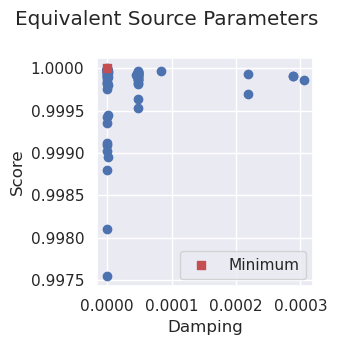

In [ ]:
df = best_eqs_per_line
# df=df.sort_values(by="dampings")

best = df.score.argmax()
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

fig, ax = plt.subplots(figsize=(3.5, 3.5))
plt.suptitle("Equivalent Source Parameters")

# Dampings
ax.scatter(
    df.damping,
    df.score,
    marker="o",
)
ax.scatter(
    df.damping.iloc[best],
    df.score.iloc[best],
    marker="s",
    # markersize=10,
    color=sns.color_palette()[3],
    label="Minimum",
)
ax.legend(loc="best")
ax.set_xlabel("Damping")
ax.set_ylabel("Score")

ylims = [0.995, 1.0005]
# ax.set_ylim(ylims)

plt.tight_layout()

## Individually upward continue data 

In [178]:
plot = False

# df = rosetta_blocked[rosetta_blocked.line.isin(best_eqs_per_line.line.unique())].copy()

grouped = rosetta_blocked.copy()
grouped["up_cont_grav"] = np.nan
grouped = grouped.groupby("line")

line_numbers = []
up_cont_RMSE = []
line_dfs = []
for line, df in tqdm(grouped, desc="Lines"):
    eq_fitted = best_eqs_per_line[best_eqs_per_line.line == line].eq_fitted.iloc[0]

    # up cont to 1km at same points as before
    up_cont_height = 1e3
    values = eq_fitted.predict(
        (df.easting, df.northing, np.ones_like(df.northing) * up_cont_height)
    )
    df.loc[df.line == line, "up_cont_grav"] = values

    if plot is True:
        grav.plot_line_and_crosses(
            df,
            line=line,
            y=["Height", "FAG_levelled", "up_cont_grav"],
        )

    # reset Height to new heights
    df["Height"] = up_cont_height

    # compare to original gravity
    df["dif"] = df.up_cont_grav - df.FAG_levelled

    rmse = utils.rmse(df[df.line == line].dif)

    line_numbers.append(line)
    up_cont_RMSE.append(rmse)
    line_dfs.append(df)

rosetta_UC = pd.concat(line_dfs)

eq_diffs = pd.DataFrame(
    {"line": line_numbers, "up_cont_RMSE": up_cont_RMSE}
).sort_values(by="up_cont_RMSE", ascending=False)
eq_diffs

Lines:   0%|          | 0/68 [00:00<?, ?it/s]

line  up_cont_RMSE
1     50.0      1.719856
2     80.0      0.981858
3    110.0      0.843061
54   900.0      0.784209
52   880.0      0.765193
..     ...           ...
63  1080.0      0.290543
30   590.0      0.289732
62  1070.0      0.281469
29   570.0      0.257050
20   450.0      0.184466

[68 rows x 2 columns]

## Update the misties

In [179]:
print(f"Previous mistie RMSE: {utils.rmse(inters.mistie_before_UC)}")
inters, rosetta_UC = RIS_grav.calculate_misties(
    inters,
    rosetta_UC,
    data_col="up_cont_grav",
    mistie_name="mistie_after_UC",
    # plot=True,
    robust=False,
)
print(f"Updated mistie RMSE: {utils.rmse(inters.mistie_after_UC)}")
inters.sort_values(by="mistie_after_UC").head()

Previous mistie RMSE: 5.498640739815687
Updated mistie RMSE: 5.459723781868598


line1   line2   max_dist        easting      northing  dist_along_line1  \
430  900.0  1120.0  43.162037  221717.580801 -1.340639e+06        298.011709   
219  570.0  1140.0  21.841974  331789.980110 -1.010405e+06     878331.819658   
139  470.0  1080.0  23.011564    1628.803221 -9.105217e+05     221124.697059   
142  470.0  1120.0  45.784280  221728.989944 -9.105076e+05       1024.510116   
131  450.0  1120.0  43.367139  221715.809338 -8.904958e+05     778264.612225   

     dist_along_line2  line1_value  line2_value  mistie_before_UC  \
430     488765.962690   -86.156205   -56.955190        -32.073100   
219     164457.167883   -51.426317   -34.503460        -16.787859   
139     444319.097936   -42.751547   -30.409129        -12.605192   
142      58634.994370   -38.318881   -26.536611        -12.475752   
131      38623.149362   -45.240666   -34.144729        -10.915196   

                                geometry  mistie_after_UC  
430  POINT (221717.58080 -1340638.59959)       -29.201016  
219  POINT (331789.98011 -1010404.82335)       -16.922857  
139     POINT (1628.80322 -910521.68594)       -12.342418  
142   POINT (221728.98994 -910507.63060)       -11.782270  
131   POINT (221715.80934 -890495.77861)       -11.095938

## Save and load from csv

In [180]:
rosetta_UC.to_csv(
    "../../data/ROSETTA_UC.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
inters.to_file(
    "../../data/ROSETTA_UC_intersections.gpkg",
)

In [3]:
rosetta_UC = pd.read_csv(
    "../../data/ROSETTA_UC.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inters = gpd.GeoDataFrame.from_file(
    "../../data/ROSETTA_UC_intersections.gpkg",
)
inters

line1   line2   max_dist        easting      northing  dist_along_line1  \
0     50.0  1040.0  36.094627 -218366.620807 -4.903223e+05      75298.725128   
1     80.0  1040.0  40.828308 -218370.298672 -5.204792e+05      66357.166666   
2    110.0  1040.0  36.542176 -218370.463581 -5.503800e+05      26674.343360   
3    110.0  1050.0  26.504606 -163372.861101 -5.504074e+05      81671.935836   
4    140.0  1040.0  22.845900 -218372.911205 -5.804105e+05     116398.747036   
..     ...     ...        ...            ...           ...               ...   
429  900.0  1100.0  20.145595  111630.697151 -1.340633e+06     110384.895506   
430  900.0  1120.0  43.162037  221717.580801 -1.340639e+06        298.011709   
431  910.0  1090.0  38.771702   56714.623014 -1.350705e+06     201913.467149   
432  910.0  1100.0  34.282318  111651.804935 -1.350666e+06     146976.273442   
433  910.0  1120.0  42.597968  221725.710905 -1.350631e+06      36902.362472   

     dist_along_line2  line1_value  line2_value  mistie_before_UC  \
0         1198.206719   -50.687204   -49.880391          0.000089   
1        31355.160096   -47.242799   -47.121007          0.000014   
2        61255.941746   -47.370613   -41.035108         -6.170917   
3        22642.697747   -39.377242   -45.280061          6.171114   
4        91286.435692   -36.980911   -37.252233          0.340261   
..                ...          ...          ...               ...   
429      20520.911715     0.972294    -5.343445          6.424137   
430     488765.962690   -86.156205   -56.955190        -32.073100   
431     674921.894773   -35.533474   -35.455919         -0.331420   
432      10487.353108    -9.913467    -7.066569         -2.756782   
433     498757.993348   -59.023128   -62.204412          3.087833   

     mistie_after_UC                             geometry  
0          -0.806813  POINT (-218366.62081 -490322.26644)  
1          -0.121791  POINT (-218370.29867 -520479.22000)  
2          -6.335505  POINT (-218370.46358 -550380.00170)  
3           5.902819  POINT (-163372.86110 -550407.44105)  
4           0.271322  POINT (-218372.91121 -580410.49556)  
..               ...                                  ...  
429         6.315739  POINT (111630.69715 -1340632.76457)  
430       -29.201016  POINT (221717.58080 -1340638.59959)  
431        -0.077556   POINT (56714.62301 -1350705.46036)  
432        -2.846898  POINT (111651.80494 -1350666.32264)  
433         3.181283  POINT (221725.71090 -1350630.63058)  

[434 rows x 12 columns]

In [182]:
# RIS_grav.plotly_points(
#     rosetta_UC,
#     color_col="dif",
#     hover_cols=["FAG_levelled", "up_cont_grav", "dif", "Height", "line"],
#     robust=True,
#     # point_size=5,
# )

In [183]:
# RIS_grav.plotly_points(
#     rosetta_UC,
#     color_col="FAG_levelled",
#     hover_cols=["FAG_levelled", "up_cont_grav", "dif", "Height", "line"],
#     robust=True,
#     # point_size=5,
# )

In [184]:
# RIS_grav.plotly_points(
#     rosetta_UC,
#     color_col="up_cont_grav",
#     hover_cols=["FAG_levelled", "up_cont_grav", "dif", "Height", "line"],
#     robust=True,
#     # point_size=5,
# )

In [185]:
# RIS_grav.plot_line_and_crosses(
#     df,
#     line=80,
#     y=["Height", "FAG_levelled", "up_cont_grav",],
# )

## Grid the data

In [11]:
coords = (
    rosetta_UC.easting,
    rosetta_UC.northing,
    np.ones_like(rosetta_UC.northing) * 1e3,
)
data = rosetta_UC.up_cont_grav

# study, eqs = optimization.optimize_eq_source_params(
#     coords,
#     data,
#     n_trials=3,
#     # damping_limits=[1e-40,10],
#     damping=1e2,
#     depth="default",
#     block_size=5e3,
#     plot=False,
#     progressbar=True,
# )

eqs = hm.EquivalentSources(damping=10, depth="default", block_size=5e3)
eqs.fit(coords, data)

EquivalentSources(block_size=5000.0, damping=10)

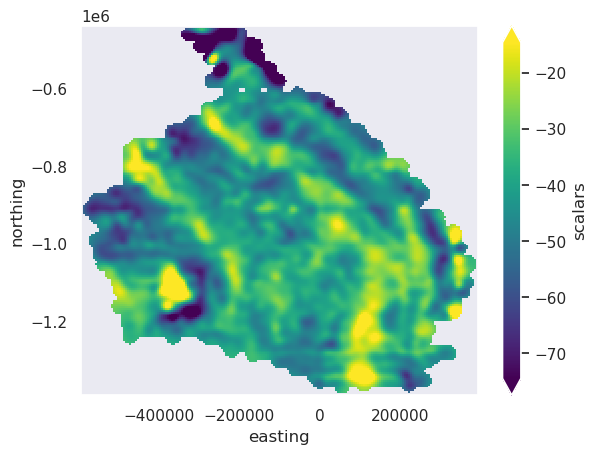

In [12]:
# Define grid coordinates
region = vd.pad_region(vd.get_region(coords), 20e3)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=1e3,  # upward continue to 1km
)

grid_before_level = eqs.grid(grid_coords)

masked_before_level = vd.distance_mask(
    (coords[0], coords[1]), maxdist=20e3, grid=grid_before_level
)
masked_before_level = masked_before_level.reset_coords(names="upward").scalars
masked_before_level.plot(robust=True)

# Exclude certain intersections

In [13]:
# exclude based on max distance to real points
cutoff_dist = 20e3

prior_len = len(inters)

inters2 = inters[inters.max_dist < cutoff_dist].copy()
print(
    f"removed {prior_len - len(inters2)} intersections points which were",
    f"further than {int(cutoff_dist/1000)}km from nearest data point",
)

removed 6 intersections points which were further than 20km from nearest data point


In [ ]:
exclude_inds = []

ind = inters2[(inters2.line1 == 470) & (inters2.line2 == 1070)].index.values
exclude_inds.extend(ind)

# ind = inters2[(inters2.line1==1120) | (inters2.line2==1120)].index.values
# exclude_inds.extend(ind)

# drop intersections from inters
inters2 = inters2.drop(index=exclude_inds, errors="ignore")

print(f"removed {len(exclude_inds)} intersection")
print(f"{len(inters2)} intersections remaining")

removed 1 intersection
427 intersections remaining


In [15]:
# Only keep intersection rows in gravity df if they are in ther intersection df
inds_to_keep = []
for i, row in inters2.iterrows():
    line1 = row.line1
    line2 = row.line2

    ind = rosetta_UC[
        (rosetta_UC.is_intersection)
        & ((rosetta_UC.line == line1) & (rosetta_UC.intersecting_line == line2))
        | ((rosetta_UC.line == line2) & (rosetta_UC.intersecting_line == line1))
    ].index.values
    inds_to_keep.extend(ind)

print(
    f"removed {len(rosetta_UC[rosetta_UC.is_intersection])-len(inds_to_keep)} intersections"
)

inds_to_keep.extend(rosetta_UC[~rosetta_UC.is_intersection].index.values)

# drop intersection row from gravity df
df = rosetta_UC[rosetta_UC.index.isin(inds_to_keep)]

print(f"{len(df[df.is_intersection])} intersections remaining")
print(f"{len(df)} total points remaining")

removed 14 intersections
854 intersections remaining
37818 total points remaining


In [ ]:
# # completely delete line
# rosetta_UC=rosetta_UC.drop(index=rosetta_UC[rosetta_UC.line==1120].index, errors="ignore")
# rosetta_UC.line.unique()

In [16]:
print(f"Mistie RMS before dropping intersections: {utils.rmse(inters.mistie_after_UC)}")
inters = inters2.copy()
rosetta_UC = df.copy()
print(f"Mistie RMS after dropping intersections: {utils.rmse(inters.mistie_after_UC)}")
inters.sort_values(by="mistie_after_UC").head()

Mistie RMS before dropping intersections: 5.459723781868598
Mistie RMS after dropping intersections: 5.1995594025686875


line1   line2   max_dist        easting      northing  dist_along_line1  \
430  900.0  1120.0  43.162037  221717.580801 -1.340639e+06        298.011709   
219  570.0  1140.0  21.841974  331789.980110 -1.010405e+06     878331.819658   
139  470.0  1080.0  23.011564    1628.803221 -9.105217e+05     221124.697059   
142  470.0  1120.0  45.784280  221728.989944 -9.105076e+05       1024.510116   
131  450.0  1120.0  43.367139  221715.809338 -8.904958e+05     778264.612225   

     dist_along_line2  line1_value  line2_value  mistie_before_UC  \
430     488765.962690   -86.156205   -56.955190        -32.073100   
219     164457.167883   -51.426317   -34.503460        -16.787859   
139     444319.097936   -42.751547   -30.409129        -12.605192   
142      58634.994370   -38.318881   -26.536611        -12.475752   
131      38623.149362   -45.240666   -34.144729        -10.915196   

     mistie_after_UC                             geometry  
430       -29.201016  POINT (221717.58080 -1340638.59959)  
219       -16.922857  POINT (331789.98011 -1010404.82335)  
139       -12.342418     POINT (1628.80322 -910521.68594)  
142       -11.782270   POINT (221728.98994 -910507.63060)  
131       -11.095938   POINT (221715.80934 -890495.77861)

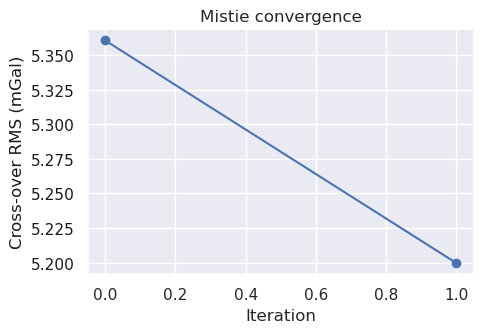

In [18]:
RIS_grav.plot_levelling_convergence(
    rosetta_UC,
    mistie_prefix="mistie",
    title="Mistie convergence",
    # logy=True,
)

# Alternative between lines and ties

## 0th order

Starting RMSE mistie: 5.1995594025686875 mGal
RMSE mistie after iteration 1: L -> T: 4.96278753432544 mGal
RMS correction to lines: 1.5803463336800752 mGal
RMSE mistie after iteration 1: T -> L: 4.793913648112933 mGal
RMS correction to ties: 1.3416407513473267 mGal
RMSE mistie after iteration 2: L -> T: 4.78646578929957 mGal
RMS correction to lines: 0.26724867812912506 mGal
RMSE mistie after iteration 2: T -> L: 4.785995040500169 mGal
RMS correction to ties: 0.07043934949872765 mGal
RMSE mistie after iteration 3: L -> T: 4.785959156488857 mGal
RMS correction to lines: 0.01872845303855767 mGal
RMSE mistie after iteration 3: T -> L: 4.785956078484272 mGal
RMS correction to ties: 0.005878030481131837 mGal
RMSE mistie after iteration 4: L -> T: 4.785955792361473 mGal
RMS correction to lines: 0.001674701887657906 mGal
RMSE mistie after iteration 4: T -> L: 4.785955764289875 mGal
RMS correction to ties: 0.0005791693250764205 mGal
RMSE mistie after iteration 5: L -> T: 4.785955761433357 mGal


easting      northing    line   LATITUDE   LONGITUDE  \
0     -323017.301127 -4.604725e+05    20.0 -84.827798 -144.950697   
1     -321997.009961 -4.604783e+05    20.0 -84.833130 -145.036205   
2     -320976.263358 -4.604806e+05    20.0 -84.838479 -145.121727   
3     -319954.356535 -4.604793e+05    20.0 -84.843849 -145.207317   
4     -318974.502480 -4.604769e+05    20.0 -84.848997 -145.289477   
...              ...           ...     ...        ...         ...   
37827  331826.687432 -1.100608e+06  1140.0        NaN         NaN   
37828  331826.259411 -1.070505e+06  1140.0        NaN         NaN   
37829  331840.937091 -1.050564e+06  1140.0        NaN         NaN   
37830  331832.763929 -1.040655e+06  1140.0        NaN         NaN   
37831  331789.980110 -1.010405e+06  1140.0        NaN         NaN   

           unixtime  Height  FAG_levelled  dist_along_line  mistie_before_UC  \
0      1.480724e+09  1000.0    -79.585185    124715.592483               NaN   
1      1.480724e+09  1000.0    -79.477289    123695.301723               NaN   
2      1.480724e+09  1000.0    -79.280965    122674.555360               NaN   
3      1.480724e+09  1000.0    -79.010975    121652.648406               NaN   
4      1.480724e+09  1000.0    -78.693828    120672.794120               NaN   
...             ...     ...           ...              ...               ...   
37827           NaN  1000.0    -41.511223     74254.443110          5.295003   
37828           NaN  1000.0    -31.341988    104357.487900          1.763079   
37829           NaN  1000.0    -32.080697    124298.192629          1.681957   
37830           NaN  1000.0    -33.006908    134206.942814          4.427681   
37831           NaN  1000.0    -35.124642    164457.167883        -16.787859   

       ...  mistie_trend0_3t  levelled_data_trend0_4l  mistie_trend0_4l  \
0      ...               NaN               -78.414374               NaN   
1      ...               NaN               -78.431787               NaN   
2      ...               NaN               -78.296225               NaN   
3      ...               NaN               -78.077278               NaN   
4      ...               NaN               -77.792048               NaN   
...    ...               ...                      ...               ...   
37827  ...          4.231613               -42.289387          4.233578   
37828  ...          1.235036               -32.372546          1.236739   
37829  ...          2.866928               -33.037896          2.868630   
37830  ...          5.635594               -33.900627          5.637296   
37831  ...        -15.333697               -35.774219        -15.331994   

       levelled_data_trend0_4t  mistie_trend0_4t  levelled_data_trend0_5l  \
0                   -78.414374               NaN               -78.414374   
1                   -78.431787               NaN               -78.431787   
2                   -78.296225               NaN               -78.296225   
3                   -78.077278               NaN               -78.077278   
4                   -77.792048               NaN               -77.792048   
...                        ...               ...                      ...   
37827               -42.287780          4.231971               -42.287780   
37828               -32.370939          1.235132               -32.370939   
37829               -33.036289          2.867023               -33.036289   
37830               -33.899020          5.635689               -33.899020   
37831               -35.772612        -15.333601               -35.772612   

       mistie_trend0_5l  levelled_data_trend0_5t  mistie_trend0_5t  \
0                   NaN               -78.414374               NaN   
1                   NaN               -78.431787               NaN   
2                   NaN               -78.296225               NaN   
3                   NaN               -78.077278               NaN   
4                   NaN               -77.79204

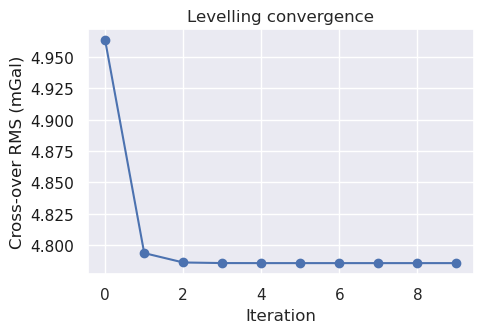

In [23]:
# perform iterative leveling, alternating between flight and tie lines
rosetta_UC_levelled_trend0, inters_levelled_trend0 = (
    RIS_grav.iterative_levelling_alternate(
        inters,
        rosetta_UC,
        tie_line_names=rosetta_UC.line[rosetta_UC.line >= 1000].unique(),
        flight_line_names=rosetta_UC.line[rosetta_UC.line < 1000].unique(),
        degree=0,
        starting_mistie_col="mistie_after_UC",
        starting_data_col="up_cont_grav",
        iterations=5,
        # plot_iterations=True,
        # plot_results=True,
        plot_convergence=True,
    )
)

final_mistie_col_trend0 = list(rosetta_UC_levelled_trend0.columns)[-1]
final_data_col_trend0 = list(rosetta_UC_levelled_trend0.columns)[-2]

rosetta_UC_levelled_trend0["total_level_corr"] = (
    rosetta_UC_levelled_trend0[final_data_col_trend0]
    - rosetta_UC_levelled_trend0.up_cont_grav
)

rosetta_UC_levelled_trend0

## 1st order

Starting RMSE mistie: 4.785955761134744 mGal
RMSE mistie after iteration 1: L -> T: 4.223564084368782 mGal
RMS correction to lines: 2.21712780718453 mGal
RMSE mistie after iteration 1: T -> L: 4.002080871426328 mGal
RMS correction to ties: 1.7502250844519416 mGal
RMSE mistie after iteration 2: L -> T: 3.9437654161707205 mGal
RMS correction to lines: 0.7925480546846957 mGal
RMSE mistie after iteration 2: T -> L: 3.9228048838055862 mGal
RMS correction to ties: 0.5479528625953115 mGal
RMSE mistie after iteration 3: L -> T: 3.9139255696505346 mGal
RMS correction to lines: 0.30439155293887105 mGal
RMSE mistie after iteration 3: T -> L: 3.9098198162358466 mGal
RMS correction to ties: 0.22558878351386408 mGal
RMSE mistie after iteration 4: L -> T: 3.907809913825899 mGal
RMS correction to lines: 0.14205222901425885 mGal
RMSE mistie after iteration 4: T -> L: 3.9067807292027754 mGal
RMS correction to ties: 0.10433266627253551 mGal
RMSE mistie after iteration 5: L -> T: 3.9062330105675387 mGal
R

easting      northing    line   LATITUDE   LONGITUDE  \
0     -323017.301127 -4.604725e+05    20.0 -84.827798 -144.950697   
1     -321997.009961 -4.604783e+05    20.0 -84.833130 -145.036205   
2     -320976.263358 -4.604806e+05    20.0 -84.838479 -145.121727   
3     -319954.356535 -4.604793e+05    20.0 -84.843849 -145.207317   
4     -318974.502480 -4.604769e+05    20.0 -84.848997 -145.289477   
...              ...           ...     ...        ...         ...   
37827  331826.687432 -1.100608e+06  1140.0        NaN         NaN   
37828  331826.259411 -1.070505e+06  1140.0        NaN         NaN   
37829  331840.937091 -1.050564e+06  1140.0        NaN         NaN   
37830  331832.763929 -1.040655e+06  1140.0        NaN         NaN   
37831  331789.980110 -1.010405e+06  1140.0        NaN         NaN   

           unixtime  Height  FAG_levelled  dist_along_line  mistie_before_UC  \
0      1.480724e+09  1000.0    -79.585185    124715.592483               NaN   
1      1.480724e+09  1000.0    -79.477289    123695.301723               NaN   
2      1.480724e+09  1000.0    -79.280965    122674.555360               NaN   
3      1.480724e+09  1000.0    -79.010975    121652.648406               NaN   
4      1.480724e+09  1000.0    -78.693828    120672.794120               NaN   
...             ...     ...           ...              ...               ...   
37827           NaN  1000.0    -41.511223     74254.443110          5.295003   
37828           NaN  1000.0    -31.341988    104357.487900          1.763079   
37829           NaN  1000.0    -32.080697    124298.192629          1.681957   
37830           NaN  1000.0    -33.006908    134206.942814          4.427681   
37831           NaN  1000.0    -35.124642    164457.167883        -16.787859   

       ...  levelled_data_trend1_3t  mistie_trend1_3t  \
0      ...               -78.414374               NaN   
1      ...               -78.431787               NaN   
2      ...               -78.296225               NaN   
3      ...               -78.077278               NaN   
4      ...               -77.792048               NaN   
...    ...                      ...               ...   
37827  ...               -39.575816          3.272246   
37828  ...               -34.028703         -5.267688   
37829  ...               -37.588626          3.183704   
37830  ...               -39.889701          5.881832   
37831  ...               -46.154385         -4.720782   

       levelled_data_trend1_4l  mistie_trend1_4l  levelled_data_trend1_4t  \
0                   -78.414374               NaN               -78.414374   
1                   -78.431787               NaN               -78.431787   
2                   -78.296225               NaN               -78.296225   
3                   -78.077278               NaN               -78.077278   
4                   -77.792048               NaN               -77.792048   
...                        ...               ...                      ...   
37827               -39.575816          3.199339               -39.620763   
37828               -34.028703         -5.445392               -34.204754   
37829               -37.588626          2.921259               -37.851522   
37830               -39.889701          5.577427               -40.195752   
37831               -46.154385         -5.153656               -46.592181   

       mistie_trend1_4t  levelled_data_trend1_5l  mistie_trend1_5l  \
0                   NaN               -78.414374               NaN   
1                   NaN               -78.431787               NaN   
2                   NaN               -78.296225               NaN   
3                   NaN               -78.077278               NaN   
4                   NaN               -77.792048               NaN   
...                 ...                      ...               ...   
37827          3.244286               -39.620763          3.164675   
37828         -5.269342               -34.204754     

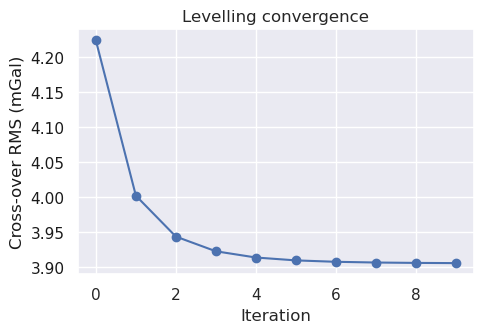

In [24]:
# perform iterative leveling, alternating between flight and tie lines
rosetta_UC_levelled_trend1, inters_levelled_trend1 = (
    RIS_grav.iterative_levelling_alternate(
        inters_levelled_trend0,
        rosetta_UC_levelled_trend0,
        tie_line_names=rosetta_UC_levelled_trend0.line[
            rosetta_UC_levelled_trend0.line >= 1000
        ].unique(),
        flight_line_names=rosetta_UC_levelled_trend0.line[
            rosetta_UC_levelled_trend0.line < 1000
        ].unique(),
        degree=1,
        starting_mistie_col=final_mistie_col_trend0,
        starting_data_col=final_data_col_trend0,
        iterations=5,
        # plot_iterations=True,
        # plot_results=True,
        plot_convergence=True,
    )
)

final_mistie_col_trend1 = list(rosetta_UC_levelled_trend1.columns)[-1]
final_data_col_trend1 = list(rosetta_UC_levelled_trend1.columns)[-2]

rosetta_UC_levelled_trend1["total_level_corr"] = (
    rosetta_UC_levelled_trend1[final_data_col_trend1]
    - rosetta_UC_levelled_trend1.up_cont_grav
)

rosetta_UC_levelled_trend1

In [25]:
coords = (
    rosetta_UC_levelled_trend1.easting,
    rosetta_UC_levelled_trend1.northing,
    np.ones_like(rosetta_UC_levelled_trend1.northing) * 1e3,
)
data = rosetta_UC_levelled_trend1[final_data_col_trend1]

# study, eqs = optimization.optimize_eq_source_params(
#     coords,
#     data,
#     n_trials=20,
#     damping_limits=[1e-40,10],
#     depth="default",
#     block_size=1e3,
#     plot=False,
#     progressbar=True,
# )

eqs = hm.EquivalentSources(damping=10, depth="default", block_size=5e3)
eqs.fit(coords, data)

EquivalentSources(block_size=5000.0, damping=10)

In [26]:
# Define grid coordinates
region = vd.pad_region(vd.get_region(coords), 20e3)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=1e3,  # upward continue to 1km
)

grid_alt_trend1 = eqs.grid(grid_coords)

masked_alt_trend1 = vd.distance_mask(
    (coords[0], coords[1]), maxdist=20e3, grid=grid_alt_trend1
)
masked_alt_trend1 = masked_alt_trend1.reset_coords(names="upward").scalars

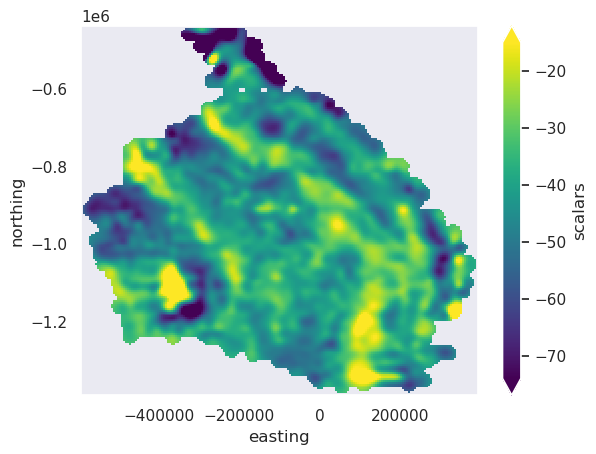

In [27]:
masked_alt_trend1.plot(robust=True)

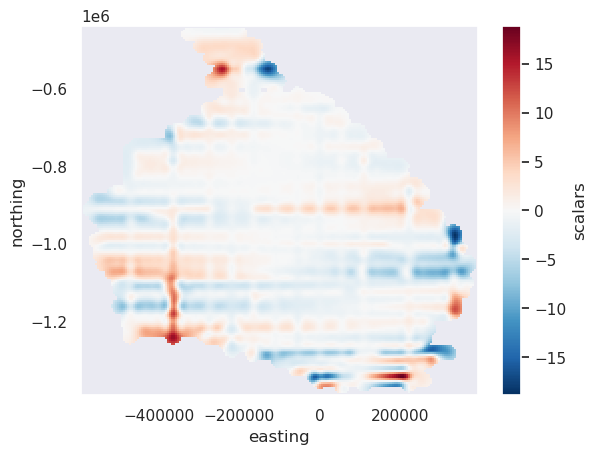

In [28]:
(masked_alt_trend1 - masked_before_level).plot()

## 2nd order

Starting RMSE mistie: 3.905931648911269 mGal
RMSE mistie after iteration 1: L -> T: 3.587311853566 mGal
RMS correction to lines: 1.9235394470578633 mGal
RMSE mistie after iteration 1: T -> L: 3.4857540909614935 mGal
RMS correction to ties: 1.082621227745386 mGal
RMSE mistie after iteration 2: L -> T: 3.455237706960223 mGal
RMS correction to lines: 0.7361627599451027 mGal
RMSE mistie after iteration 2: T -> L: 3.4426270732364093 mGal
RMS correction to ties: 0.4601612792690922 mGal
RMSE mistie after iteration 3: L -> T: 3.436659768918749 mGal
RMS correction to lines: 0.2625635312351618 mGal
RMSE mistie after iteration 3: T -> L: 3.43356049221659 mGal
RMS correction to ties: 0.25076247178264005 mGal
RMSE mistie after iteration 4: L -> T: 3.4318054174297217 mGal
RMS correction to lines: 0.12753375115011858 mGal
RMSE mistie after iteration 4: T -> L: 3.4307241388817777 mGal
RMS correction to ties: 0.15293273380322664 mGal
RMSE mistie after iteration 5: L -> T: 3.4300035784919873 mGal
RMS co

easting      northing    line   LATITUDE   LONGITUDE  \
0     -323017.301127 -4.604725e+05    20.0 -84.827798 -144.950697   
1     -321997.009961 -4.604783e+05    20.0 -84.833130 -145.036205   
2     -320976.263358 -4.604806e+05    20.0 -84.838479 -145.121727   
3     -319954.356535 -4.604793e+05    20.0 -84.843849 -145.207317   
4     -318974.502480 -4.604769e+05    20.0 -84.848997 -145.289477   
...              ...           ...     ...        ...         ...   
37827  331826.687432 -1.100608e+06  1140.0        NaN         NaN   
37828  331826.259411 -1.070505e+06  1140.0        NaN         NaN   
37829  331840.937091 -1.050564e+06  1140.0        NaN         NaN   
37830  331832.763929 -1.040655e+06  1140.0        NaN         NaN   
37831  331789.980110 -1.010405e+06  1140.0        NaN         NaN   

           unixtime  Height  FAG_levelled  dist_along_line  mistie_before_UC  \
0      1.480724e+09  1000.0    -79.585185    124715.592483               NaN   
1      1.480724e+09  1000.0    -79.477289    123695.301723               NaN   
2      1.480724e+09  1000.0    -79.280965    122674.555360               NaN   
3      1.480724e+09  1000.0    -79.010975    121652.648406               NaN   
4      1.480724e+09  1000.0    -78.693828    120672.794120               NaN   
...             ...     ...           ...              ...               ...   
37827           NaN  1000.0    -41.511223     74254.443110          5.295003   
37828           NaN  1000.0    -31.341988    104357.487900          1.763079   
37829           NaN  1000.0    -32.080697    124298.192629          1.681957   
37830           NaN  1000.0    -33.006908    134206.942814          4.427681   
37831           NaN  1000.0    -35.124642    164457.167883        -16.787859   

       ...  levelled_data_trend2_8t  mistie_trend2_8t  \
0      ...               -78.414374               NaN   
1      ...               -78.431787               NaN   
2      ...               -78.296225               NaN   
3      ...               -78.077278               NaN   
4      ...               -77.792048               NaN   
...    ...                      ...               ...   
37827  ...               -41.246640          0.612776   
37828  ...               -33.682907         -4.716260   
37829  ...               -37.549638          1.089518   
37830  ...               -40.490035          3.710098   
37831  ...               -50.706195         -1.447126   

       levelled_data_trend2_9l  mistie_trend2_9l  levelled_data_trend2_9t  \
0                   -78.414374               NaN               -78.414374   
1                   -78.431787               NaN               -78.431787   
2                   -78.296225               NaN               -78.296225   
3                   -78.077278               NaN               -78.077278   
4                   -77.792048               NaN               -77.792048   
...                        ...               ...                      ...   
37827               -41.246640          0.558673               -41.303169   
37828               -33.682907         -4.717791               -33.683806   
37829               -37.549638          1.105295               -37.533472   
37830               -40.490035          3.728645               -40.471253   
37831               -50.706195         -1.444107               -50.703513   

       mistie_trend2_9t  levelled_data_trend2_10l  mistie_trend2_10l  \
0                   NaN                -78.414374                NaN   
1                   NaN                -78.431787                NaN   
2                   NaN                -78.296225                NaN   
3                   NaN                -78.077278                NaN   
4                   NaN                -77.792048                NaN   
...                 ...                       ...                ...   
37827          0.615202                -41.303169           0.566558   
37828         -4.716892              

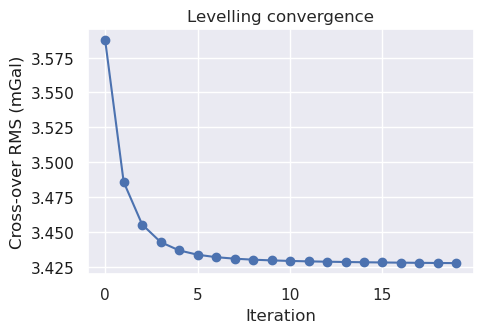

In [29]:
# perform iterative leveling, alternating between flight and tie lines
rosetta_UC_levelled_trend2, inters_levelled_trend2 = (
    RIS_grav.iterative_levelling_alternate(
        inters_levelled_trend1,
        rosetta_UC_levelled_trend1,
        tie_line_names=rosetta_UC_levelled_trend1.line[
            rosetta_UC_levelled_trend1.line >= 1000
        ].unique(),
        flight_line_names=rosetta_UC_levelled_trend1.line[
            rosetta_UC_levelled_trend1.line < 1000
        ].unique(),
        degree=2,
        starting_mistie_col=final_mistie_col_trend1,
        starting_data_col=final_data_col_trend1,
        iterations=10,
        # plot_iterations=True,
        # plot_results=True,
        plot_convergence=True,
    )
)

final_mistie_col_trend2 = list(rosetta_UC_levelled_trend2.columns)[-1]
final_data_col_trend2 = list(rosetta_UC_levelled_trend2.columns)[-2]

rosetta_UC_levelled_trend2["total_level_corr"] = (
    rosetta_UC_levelled_trend2[final_data_col_trend2]
    - rosetta_UC_levelled_trend2.up_cont_grav
)

rosetta_UC_levelled_trend2

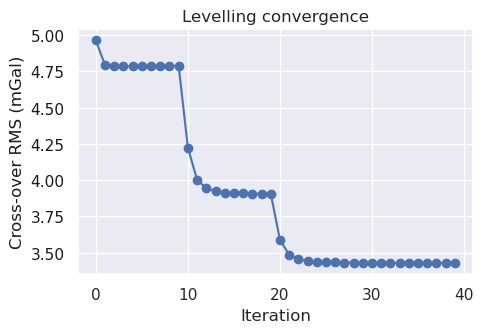

In [30]:
RIS_grav.plot_levelling_convergence(
    rosetta_UC_levelled_trend2,
    mistie_prefix="mistie_trend",
    # title = "Mistie convergence",
    # logy=True,
)

In [ ]:
# grav.plotly_points(
#     rosetta_UC_levelled_trend2,
#     coord_names=["easting", "northing"],
#     color_col=final_data_col_trend2,
#     hover_cols=[final_data_col_trend2, "Height", "line"],
#     robust=True,
#     # point_size=5,
# )

In [31]:
coords = (
    rosetta_UC_levelled_trend2.easting,
    rosetta_UC_levelled_trend2.northing,
    np.ones_like(rosetta_UC_levelled_trend2.northing) * 1e3,
)
data = rosetta_UC_levelled_trend2[final_data_col_trend2]

# study, eqs = optimization.optimize_eq_source_params(
#     coords,
#     data,
#     n_trials=20,
#     damping_limits=[1e-40,10],
#     depth="default",
#     block_size=1e3,
#     plot=False,
#     progressbar=True,
# )

eqs = hm.EquivalentSources(damping=10, depth="default", block_size=5e3)
eqs.fit(coords, data)

EquivalentSources(block_size=5000.0, damping=10)

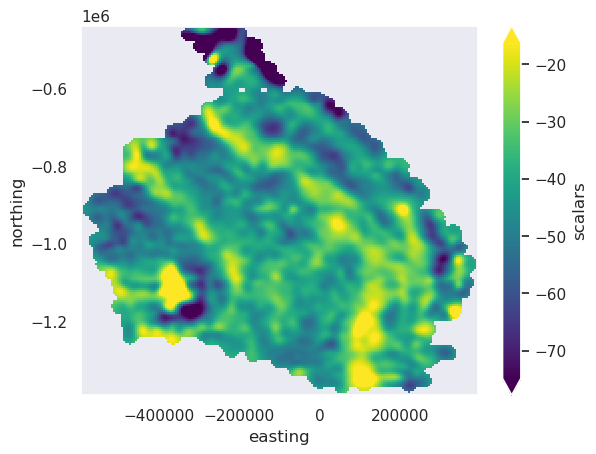

In [35]:
# Define grid coordinates
region = vd.pad_region(vd.get_region(coords), 20e3)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=1e3,  # upward continue to 1km
)

grid_alt_trend2 = eqs.grid(grid_coords)

masked_alt_trend2 = vd.distance_mask(
    (coords[0], coords[1]), maxdist=20e3, grid=grid_alt_trend2
)
masked_alt_trend2 = masked_alt_trend2.reset_coords(names="upward").scalars
masked_alt_trend2.plot(robust=True)

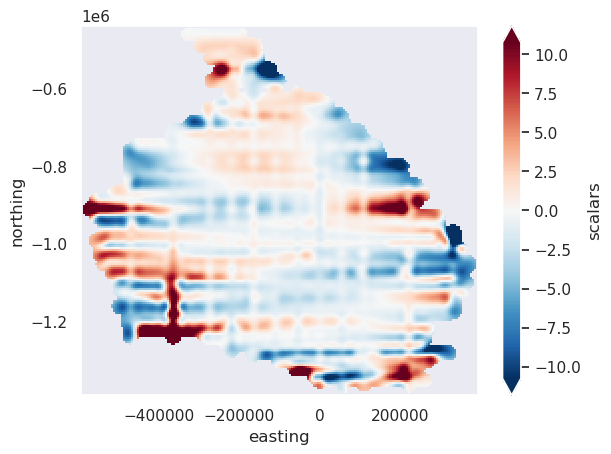

In [33]:
(masked_alt_trend2 - masked_before_level).plot(robust=True)

## Save and load from csv

In [36]:
rosetta_UC_levelled_trend2.to_csv(
    "../../data/ROSETTA_2nd_order_levelled.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
inters_levelled_trend2.to_file(
    "../../data/ROSETTA_2nd_order_levelled_intersections.gpkg",
)

In [37]:
rosetta_UC_levelled_trend2 = pd.read_csv(
    "../../data/ROSETTA_2nd_order_levelled.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inters_levelled_trend2 = gpd.GeoDataFrame.from_file(
    "../../data/ROSETTA_2nd_order_levelled_intersections.gpkg",
)
rosetta_UC_levelled_trend2

easting      northing    line   LATITUDE   LONGITUDE  \
0     -323017.301127 -4.604725e+05    20.0 -84.827798 -144.950697   
1     -321997.009961 -4.604783e+05    20.0 -84.833130 -145.036205   
2     -320976.263358 -4.604806e+05    20.0 -84.838479 -145.121727   
3     -319954.356535 -4.604793e+05    20.0 -84.843849 -145.207317   
4     -318974.502480 -4.604769e+05    20.0 -84.848997 -145.289477   
...              ...           ...     ...        ...         ...   
37813  331826.687432 -1.100608e+06  1140.0        NaN         NaN   
37814  331826.259411 -1.070505e+06  1140.0        NaN         NaN   
37815  331840.937091 -1.050564e+06  1140.0        NaN         NaN   
37816  331832.763929 -1.040655e+06  1140.0        NaN         NaN   
37817  331789.980110 -1.010405e+06  1140.0        NaN         NaN   

           unixtime  Height  FAG_levelled  dist_along_line  mistie_before_UC  \
0      1.480724e+09  1000.0    -79.585185    124715.592483               NaN   
1      1.480724e+09  1000.0    -79.477289    123695.301723               NaN   
2      1.480724e+09  1000.0    -79.280965    122674.555360               NaN   
3      1.480724e+09  1000.0    -79.010975    121652.648406               NaN   
4      1.480724e+09  1000.0    -78.693828    120672.794120               NaN   
...             ...     ...           ...              ...               ...   
37813           NaN  1000.0    -41.511223     74254.443110          5.295003   
37814           NaN  1000.0    -31.341988    104357.487900          1.763079   
37815           NaN  1000.0    -32.080697    124298.192629          1.681957   
37816           NaN  1000.0    -33.006908    134206.942814          4.427681   
37817           NaN  1000.0    -35.124642    164457.167883        -16.787859   

       ...  levelled_data_trend2_8t  mistie_trend2_8t  \
0      ...               -78.414374               NaN   
1      ...               -78.431787               NaN   
2      ...               -78.296225               NaN   
3      ...               -78.077278               NaN   
4      ...               -77.792048               NaN   
...    ...                      ...               ...   
37813  ...               -41.246640          0.612776   
37814  ...               -33.682907         -4.716260   
37815  ...               -37.549638          1.089518   
37816  ...               -40.490035          3.710098   
37817  ...               -50.706195         -1.447126   

       levelled_data_trend2_9l  mistie_trend2_9l  levelled_data_trend2_9t  \
0                   -78.414374               NaN               -78.414374   
1                   -78.431787               NaN               -78.431787   
2                   -78.296225               NaN               -78.296225   
3                   -78.077278               NaN               -78.077278   
4                   -77.792048               NaN               -77.792048   
...                        ...               ...                      ...   
37813               -41.246640          0.558673               -41.303169   
37814               -33.682907         -4.717791               -33.683806   
37815               -37.549638          1.105295               -37.533472   
37816               -40.490035          3.728645               -40.471253   
37817               -50.706195         -1.444107               -50.703513   

       mistie_trend2_9t  levelled_data_trend2_10l  mistie_trend2_10l  \
0                   NaN                -78.414374                NaN   
1                   NaN                -78.431787                NaN   
2                   NaN                -78.296225                NaN   
3                   NaN                -78.077278                NaN   
4                   NaN                -77.792048                NaN   
...                 ...                       ...                ...   
37813          0.615202                -41.303169           0.566558   
37814         -4.716892              

## 3rd order

Starting RMSE mistie: 3.4275342169549243 mGal
RMSE mistie after iteration 1: L -> T: 3.192417814390133 mGal
RMS correction to lines: 2.2031391293313116 mGal
RMSE mistie after iteration 1: T -> L: 3.122166207319696 mGal
RMS correction to ties: 2.5245002385022297 mGal
RMSE mistie after iteration 2: L -> T: 3.082391744739087 mGal
RMS correction to lines: 0.8621638761464031 mGal
RMSE mistie after iteration 2: T -> L: 3.0552464124372998 mGal
RMS correction to ties: 2.16356407517838 mGal
RMSE mistie after iteration 3: L -> T: 3.034522527625307 mGal
RMS correction to lines: 0.5498022273731424 mGal
RMSE mistie after iteration 3: T -> L: 3.01756392719186 mGal
RMS correction to ties: 1.9105911216801539 mGal
RMSE mistie after iteration 4: L -> T: 3.0031143303791246 mGal
RMS correction to lines: 0.4312591771319264 mGal
RMSE mistie after iteration 4: T -> L: 2.9905156440691347 mGal
RMS correction to ties: 1.7004806980739604 mGal
RMSE mistie after iteration 5: L -> T: 2.9793834179356247 mGal
RMS cor

easting      northing    line   LATITUDE   LONGITUDE  \
0     -323017.301127 -4.604725e+05    20.0 -84.827798 -144.950697   
1     -321997.009961 -4.604783e+05    20.0 -84.833130 -145.036205   
2     -320976.263358 -4.604806e+05    20.0 -84.838479 -145.121727   
3     -319954.356535 -4.604793e+05    20.0 -84.843849 -145.207317   
4     -318974.502480 -4.604769e+05    20.0 -84.848997 -145.289477   
...              ...           ...     ...        ...         ...   
37813  331826.687432 -1.100608e+06  1140.0        NaN         NaN   
37814  331826.259411 -1.070505e+06  1140.0        NaN         NaN   
37815  331840.937091 -1.050564e+06  1140.0        NaN         NaN   
37816  331832.763929 -1.040655e+06  1140.0        NaN         NaN   
37817  331789.980110 -1.010405e+06  1140.0        NaN         NaN   

           unixtime  Height  FAG_levelled  dist_along_line  mistie_before_UC  \
0      1.480724e+09  1000.0    -79.585185    124715.592483               NaN   
1      1.480724e+09  1000.0    -79.477289    123695.301723               NaN   
2      1.480724e+09  1000.0    -79.280965    122674.555360               NaN   
3      1.480724e+09  1000.0    -79.010975    121652.648406               NaN   
4      1.480724e+09  1000.0    -78.693828    120672.794120               NaN   
...             ...     ...           ...              ...               ...   
37813           NaN  1000.0    -41.511223     74254.443110          5.295003   
37814           NaN  1000.0    -31.341988    104357.487900          1.763079   
37815           NaN  1000.0    -32.080697    124298.192629          1.681957   
37816           NaN  1000.0    -33.006908    134206.942814          4.427681   
37817           NaN  1000.0    -35.124642    164457.167883        -16.787859   

       ...  levelled_data_trend3_8t  mistie_trend3_8t  \
0      ...               -78.414374               NaN   
1      ...               -78.431787               NaN   
2      ...               -78.296225               NaN   
3      ...               -78.077278               NaN   
4      ...               -77.792048               NaN   
...    ...                      ...               ...   
37813  ...               -50.480252          0.655593   
37814  ...               -35.118370          0.019879   
37815  ...               -29.324795         -0.001701   
37816  ...               -29.555102         -0.081726   
37817  ...               -54.174175          0.026752   

       levelled_data_trend3_9l  mistie_trend3_9l  levelled_data_trend3_9t  \
0                   -78.414374               NaN               -78.414374   
1                   -78.431787               NaN               -78.431787   
2                   -78.296225               NaN               -78.296225   
3                   -78.077278               NaN               -78.077278   
4                   -77.792048               NaN               -77.792048   
...                        ...               ...                      ...   
37813               -50.480252         -0.010868               -51.093267   
37814               -35.118370         -0.108502               -35.279205   
37815               -29.324795          0.472785               -28.848132   
37816               -29.555102          0.545689               -28.912368   
37817               -54.174175         -0.471885               -54.676413   

       mistie_trend3_9t  levelled_data_trend3_10l  mistie_trend3_10l  \
0                   NaN                -78.414374                NaN   
1                   NaN                -78.431787                NaN   
2                   NaN                -78.296225                NaN   
3                   NaN                -78.077278                NaN   
4                   NaN                -77.792048                NaN   
...                 ...                       ...                ...   
37813          0.602148                -51.093267           0.008291   
37814          0.052333              

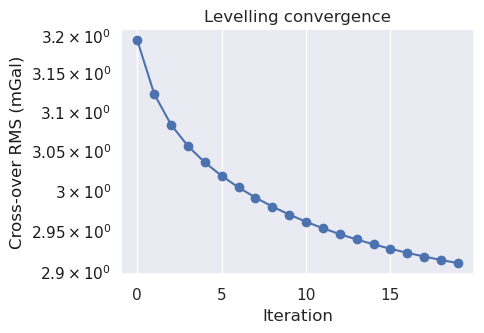

In [38]:
# perform iterative leveling, alternating between flight and tie lines
rosetta_UC_levelled_trend3, inters_levelled_trend3 = (
    RIS_grav.iterative_levelling_alternate(
        inters_levelled_trend2,
        rosetta_UC_levelled_trend2,
        tie_line_names=rosetta_UC_levelled_trend2.line[
            rosetta_UC_levelled_trend2.line >= 1000
        ].unique(),
        flight_line_names=rosetta_UC_levelled_trend2.line[
            rosetta_UC_levelled_trend2.line < 1000
        ].unique(),
        degree=3,
        starting_mistie_col=final_mistie_col_trend2,
        starting_data_col=final_data_col_trend2,
        iterations=10,
        # plot_iterations=True,
        # plot_results=True,
        plot_convergence=True,
        logy=True,
    )
)

final_mistie_col_trend3 = list(rosetta_UC_levelled_trend3.columns)[-1]
final_data_col_trend3 = list(rosetta_UC_levelled_trend3.columns)[-2]

rosetta_UC_levelled_trend3["total_level_corr"] = (
    rosetta_UC_levelled_trend3[final_data_col_trend3]
    - rosetta_UC_levelled_trend3.up_cont_grav
)

rosetta_UC_levelled_trend3

In [39]:
coords = (
    rosetta_UC_levelled_trend3.easting,
    rosetta_UC_levelled_trend3.northing,
    np.ones_like(rosetta_UC_levelled_trend3.northing) * 1e3,
)

data = rosetta_UC_levelled_trend3[final_data_col_trend3]

# study, eqs = optimization.optimize_eq_source_params(
#     coords,
#     data,
#     n_trials=20,
#     damping_limits=[1e-40,10],
#     depth="default",
#     block_size=1e3,
#     plot=False,
#     progressbar=True,
# )

eqs = hm.EquivalentSources(damping=10, depth="default", block_size=5e3)
eqs.fit(coords, data)

EquivalentSources(block_size=5000.0, damping=10)

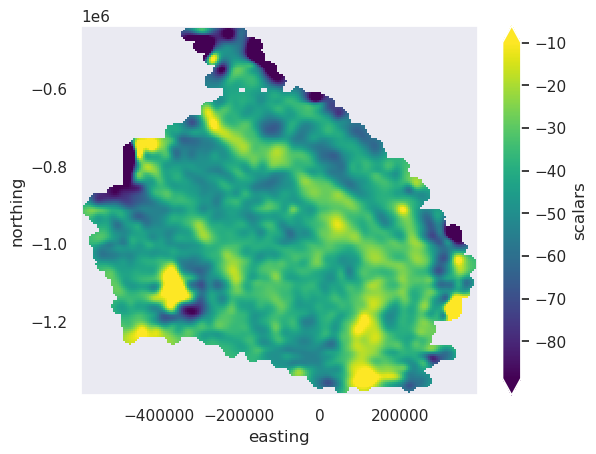

In [40]:
# Define grid coordinates
region = vd.pad_region(vd.get_region(coords), 20e3)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=1e3,  # upward continue to 1km
)

grid_alt_trend3 = eqs.grid(grid_coords)

masked_alt_trend3 = vd.distance_mask(
    (coords[0], coords[1]), maxdist=20e3, grid=grid_alt_trend3
)
masked_alt_trend3 = masked_alt_trend3.reset_coords(names="upward").scalars
masked_alt_trend3.plot(robust=True)

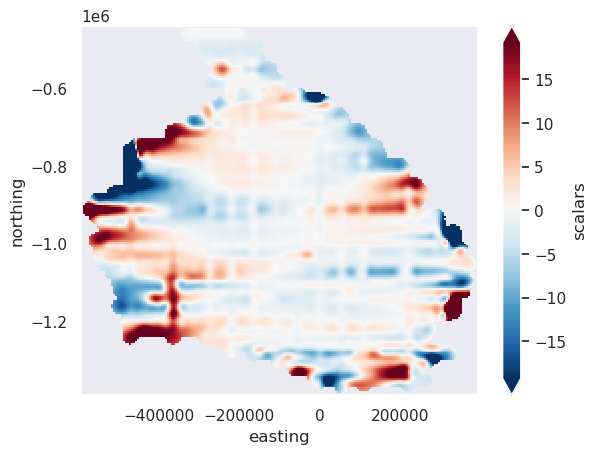

In [41]:
(masked_alt_trend3 - masked_before_level).plot(robust=True)

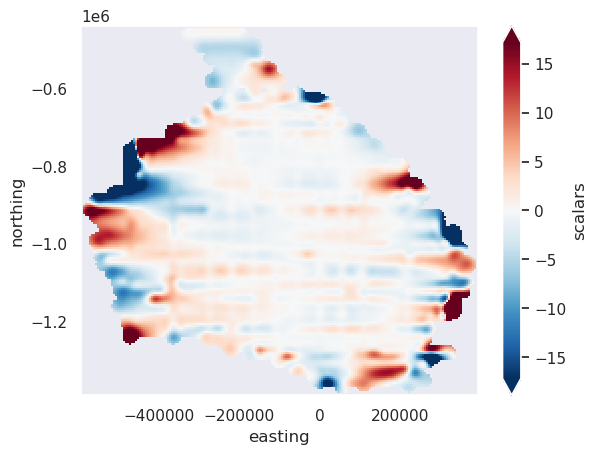

In [42]:
(masked_alt_trend3 - masked_alt_trend2).plot(robust=True)

# Just level lines, then ties
## Level lines to ties

### 0th order levelling
Apply DC-shifts to all lines to minimize mistie values

calculates least-squares trend through intersection points

In [ ]:
# # level an individual line
# line = 1090
# df1 = grav.verde_predict_trend(
#     inters[inters.line2==line],
#     ["easting", "northing", "mistie_after_UC"],
#     rosetta_UC[rosetta_UC.line==line],
#     ["easting", "northing", "levelling_correction"],
#     degree=1,
# )
# df1['levelled'] = df1.up_cont_grav - df1.levelling_correction

# grav.plot_line_and_crosses(
#     df1,
#     y=[
#         "up_cont_grav",
#         "levelled",
#         "levelling_correction",
#         "mistie_after_UC"
#     ],
#     y_axes = [1,1,1,1],
#     plot_inters = [True, False, False, False],
#     marker_sizes=[2,2,2,10]
#     )

In [ ]:
# # level an individual line
# line = 190
# df1 = grav.skl_predict_trend(
#     inters[(inters.line1==line) | (inters.line2==line)],
#     ["dist_along_line1", "mistie_after_UC"],
#     rosetta_UC[rosetta_UC.line==line],
#     ["dist_along_line", "levelling_correction"],
#     degree=1,
# )
# df1['levelled'] = df1.up_cont_grav - df1.levelling_correction

# grav.plot_line_and_crosses(
#     df1,
#     y=[
#         "up_cont_grav",
#         "levelled",
#         "levelling_correction",
#         "mistie_after_UC"
#     ],
#     y_axes = [1,1,1,1],
#     plot_inters = [True, False, False, False],
#     marker_sizes=[2,2,2,10]
#     )

In [ ]:
# # level a group of lines
# rosetta_UC1, inters1 = grav.level_lines(
#     inters,
#     rosetta_UC,
#     lines_to_level = rosetta_UC.line[rosetta_UC.line<1000].unique(),
#     cols_to_fit = "dist_along_line1",
#     cols_to_predict = "dist_along_line",
#     degree=0,
#     data_col = "up_cont_grav",
#     mistie_col = "mistie_before_UC",
#     new_mistie_col = "mistie_trend0_1",
#     levelled_col = "levelled",
#     plot=True,
# )

In [ ]:
# # perform iterative levelling, just moving lines to match ties
# rosetta_trend0, inters_trend0 = grav.iterative_line_levelling(
#     inters,
#     rosetta_UC,
#     flight_line_names=rosetta_UC.line[rosetta_UC.line < 1000].unique(),
#     degree=0,
#     starting_mistie_col="mistie_after_UC",
#     starting_data_col="up_cont_grav",
#     cols_to_fit="dist_along_line1",
#     iterations=3,
#     # plot_iterations=True,
#     # plot_results=True,
#     plot_convergence=True,
# )
# trend0_final_mistie_col = list(rosetta_trend0.columns)[-1]
# trend0_final_data_col = list(rosetta_trend0.columns)[-2]

# print(trend0_final_mistie_col)
# print(trend0_final_data_col)

# rosetta_trend0["total_level_corr"] = (
#     rosetta_trend0[trend0_final_data_col] - rosetta_trend0.up_cont_grav)

# rosetta_trend0.describe()

### 1st order levelling

In [ ]:
# # repeate at a higher order trend
# rosetta_trend1, inters_trend1 = grav.iterative_line_levelling(
#     inters_trend0,
#     rosetta_trend0,
#     flight_line_names=rosetta_trend0.line[rosetta_trend0.line < 1000].unique(),
#     degree=1,
#     starting_mistie_col=trend0_final_mistie_col,
#     starting_data_col=trend0_final_data_col,
#     cols_to_fit="dist_along_line1",
#     iterations=3,
#     # plot_iterations=True,
#     # plot_results=True,
# )
# trend1_final_mistie_col = list(rosetta_trend1.columns)[-1]
# trend1_final_data_col = list(rosetta_trend1.columns)[-2]

# print(trend1_final_mistie_col)
# print(trend1_final_data_col)

# rosetta_trend1["total_level_corr"] = (
#     rosetta_trend1[trend1_final_data_col] - rosetta_trend1.up_cont_grav)

# rosetta_trend1.describe()

In [ ]:
# grav.plotly_points(
#     rosetta_trend1,
#     color_col="total_level_corr",
#     hover_cols=["FAG_levelled", "up_cont_grav", "dif", "line"],
#     robust=True,
#     # point_size=5,
# )

In [ ]:
# grav.plotly_points(
#     rosetta_trend1,
#     color_col=trend1_final_data_col,
#     hover_cols=["FAG_levelled", "up_cont_grav", "dif", "line"],
#     robust=True,
#     # point_size=5,
# )

### 2nd order levelling

In [ ]:
# # repeat at a higher order trend
# rosetta_trend2, inters_trend2 = grav.iterative_line_levelling(
#     inters_trend1,
#     rosetta_trend1,
#     flight_line_names=rosetta_trend1.line[rosetta_trend1.line < 1000].unique(),
#     degree=2,
#     starting_mistie_col=trend1_final_mistie_col,
#     starting_data_col=trend1_final_data_col,
#     cols_to_fit="dist_along_line1",
#     iterations=3,
#     # plot_iterations=True,
#     # plot_results=True,
# )
# trend2_final_mistie_col = list(rosetta_trend2.columns)[-1]
# trend2_final_data_col = list(rosetta_trend2.columns)[-2]

# print(trend2_final_mistie_col)
# print(trend2_final_data_col)

# rosetta_trend2["total_level_corr"] = (
#     rosetta_trend2[trend2_final_data_col] - rosetta_trend2.up_cont_grav)

# rosetta_trend2.describe()

### 3rd order levelling

In [ ]:
# # repeat at a higher order trend
# rosetta_trend3, inters_trend3 = grav.iterative_line_levelling(
#     inters_trend2,
#     rosetta_trend2,
#     flight_line_names=rosetta_trend1.line[rosetta_trend2.line < 1000].unique(),
#     degree=3,
#     starting_mistie_col=trend2_final_mistie_col,
#     starting_data_col=trend2_final_data_col,
#     cols_to_fit="dist_along_line1",
#     iterations=3,
#     # plot_iterations=True,
#     # plot_results=True,
# )
# trend3_final_mistie_col = list(rosetta_trend3.columns)[-1]
# trend3_final_data_col = list(rosetta_trend3.columns)[-2]

# print(trend3_final_mistie_col)
# print(trend3_final_data_col)

# rosetta_trend3["total_level_corr"] = (
#     rosetta_trend3[trend3_final_data_col] - rosetta_trend3.up_cont_grav)

# rosetta_trend3.describe()

In [ ]:
# eqs = hm.EquivalentSources(damping=1e2, depth=10e3, block_size=2e3)

# coords = (
#     rosetta_trend3.easting,
#     rosetta_trend3.northing,
#     np.ones_like(rosetta_trend3.northing) * 1e3,
# )

# data = rosetta_trend3[trend3_final_data_col]

# eqs.fit(coords, data)

In [ ]:
# # Define grid coordinates
# region = vd.pad_region(vd.get_region(coords), 20e3)
# grid_coords = vd.grid_coordinates(
#     region=region,
#     spacing=5e3,
#     extra_coords=1e3,  # upward continue to 1km
# )

# grid_trend3 = eqs.grid(grid_coords)

# masked_trend3 = vd.distance_mask((coords[0], coords[1]), maxdist=20e3, grid=grid_trend3)
# masked_trend3 = masked_trend3.reset_coords(names="upward").scalars
# masked_trend3.plot(robust=True)

In [ ]:
# (masked_trend3-masked_before_level).plot()

## Level ties to lines

### 0th order

In [ ]:
# rosetta_ties_trend0, inters_ties_trend0 = grav.iterative_line_levelling(
#     inters_trend3,
#     rosetta_trend3,
#     flight_line_names=rosetta_trend3.line[rosetta_trend3.line >= 1000].unique(),
#     degree=0,
#     starting_mistie_col=trend3_final_mistie_col,
#     starting_data_col=trend3_final_data_col,
#     iterations=3,
#     mistie_prefix="ties_to_lines_mistie_trend",
#     levelled_data_prefix="ties_to_lines_levelled_data_trend",
#     cols_to_fit="dist_along_line2",
#     # plot_iterations=True,
#     # plot_results=True,
# )
# ties_trend0_final_mistie_col = list(rosetta_ties_trend0.columns)[-1]
# ties_trend0_final_data_col = list(rosetta_ties_trend0.columns)[-2]

# print(ties_trend0_final_mistie_col)
# print(ties_trend0_final_data_col)

# rosetta_ties_trend0["total_level_corr"] = (
#     rosetta_ties_trend0[ties_trend0_final_data_col] - rosetta_ties_trend0.up_cont_grav)

# rosetta_ties_trend0.describe()

In [ ]:
# grav.plotly_points(
#     rosetta_ties_trend0,
#     color_col=ties_trend0_final_data_col,
#     hover_cols=["FAG_levelled", "up_cont_grav", "dif", "Height", "line"],
#     robust=True,
#     # point_size=5,
# )

### 1st order

In [ ]:
# rosetta_ties_trend1, inters_ties_trend1 = grav.iterative_line_levelling(
#     inters_ties_trend0,
#     rosetta_ties_trend0,
#     flight_line_names=rosetta_ties_trend0.line[rosetta_ties_trend0.line >= 1000].unique(),
#     degree=1,
#     starting_mistie_col=ties_trend0_final_mistie_col,
#     starting_data_col=ties_trend0_final_data_col,
#     iterations=3,
#     mistie_prefix="ties_to_lines_mistie_trend",
#     levelled_data_prefix="ties_to_lines_levelled_data_trend",
#     cols_to_fit="dist_along_line2",
#     # plot_iterations=True,
#     # plot_results=True,
# )
# ties_trend1_final_mistie_col = list(rosetta_ties_trend1.columns)[-1]
# ties_trend1_final_data_col = list(rosetta_ties_trend1.columns)[-2]

# rosetta_ties_trend1["total_level_corr"] = (
#     rosetta_ties_trend1[ties_trend1_final_data_col] - rosetta_ties_trend1.up_cont_grav)

# rosetta_ties_trend1.describe()

### 2nd order

In [ ]:
# rosetta_ties_trend2, inters_ties_trend2 = grav.iterative_line_levelling(
#     inters_ties_trend1,
#     rosetta_ties_trend1,
#     flight_line_names=rosetta_ties_trend1.line[rosetta_ties_trend1.line >= 1000].unique(),
#     degree=2,
#     starting_mistie_col=ties_trend1_final_mistie_col,
#     starting_data_col=ties_trend1_final_data_col,
#     iterations=3,
#     mistie_prefix="ties_to_lines_mistie_trend",
#     levelled_data_prefix="ties_to_lines_levelled_data_trend",
#     cols_to_fit="dist_along_line2",
#     # plot_iterations=True,
#     # plot_results=True,
# )
# ties_trend2_final_mistie_col = list(rosetta_ties_trend2.columns)[-1]
# ties_trend2_final_data_col = list(rosetta_ties_trend2.columns)[-2]

# rosetta_ties_trend2["total_level_corr"] = (
#     rosetta_ties_trend2[ties_trend2_final_data_col] - rosetta_ties_trend2.up_cont_grav)

# rosetta_ties_trend2.describe()

In [ ]:
# eqs = hm.EquivalentSources(damping=1e2, depth=10e3, block_size=2e3)

# coords = (
#     rosetta_ties_trend2.easting,
#     rosetta_ties_trend2.northing,
#     np.ones_like(rosetta_ties_trend2.northing) * 1e3,
# )

# data = rosetta_ties_trend2[ties_trend2_final_data_col]

# eqs.fit(coords, data)

In [ ]:
# # Define grid coordinates
# region = vd.pad_region(vd.get_region(coords), 20e3)
# grid_coords = vd.grid_coordinates(
#     region=region,
#     spacing=5e3,
#     extra_coords=1e3,  # upward continue to 1km
# )

# grid_ties_trend2 = eqs.grid(grid_coords)

# masked_ties_trend2 = vd.distance_mask((coords[0], coords[1]), maxdist=20e3, grid=grid_ties_trend2)
# masked_ties_trend2 = masked_ties_trend2.reset_coords(names="upward").scalars
# masked_ties_trend2.plot(robust=True)

In [ ]:
# (masked_ties_trend2 - masked_before_level).plot()

# Extras

In [ ]:
# rosetta_UC, inters = RIS_grav.level_lines(
#     inters,
#     rosetta_UC,
#     lines_to_level=rosetta_UC.line[rosetta_UC.line > 1000].unique(),
#     cols_to_fit="dist_along_line2",
#     cols_to_predict="dist_along_line",
#     degree=0,
#     data_col="levelled",
#     mistie_col="mistie_3",
#     new_mistie_col="mistie_4",
#     levelled_col="levelled2",
#     plot=True,
# )

In [ ]:
# rosetta_UC, inters = RIS_grav.level_lines(
#     inters,
#     rosetta_UC,
#     lines_to_level=rosetta_UC.line[rosetta_UC.line < 1000].unique(),
#     cols_to_fit="dist_along_line1",
#     cols_to_predict="dist_along_line",
#     degree=0,
#     data_col="levelled2",
#     mistie_col="mistie_4",
#     new_mistie_col="mistie_5",
#     levelled_col="levelled3",
#     plot=True,
# )

In [ ]:
# # iterate through the E-W lines

# rosetta_UC["levelled"] = np.nan

# for line in rosetta_UC[rosetta_UC.line < 1000].line.unique():
#     df = rosetta_UC[rosetta_UC.line == line].copy()

#     # fit a polynomial trend through the misties values
#     ints = inters[inters.line1 == line]
#     coords = (ints.geometry.x, ints.geometry.y)
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="Under-determined problem")
#         try:
#             trend = vd.Trend(degree=0).fit(coords, ints.mistie_2)
#             # predict the trend on the line data
#             df["trend"] = trend.predict((df.easting, df.northing))
#         except ValueError:
#             print(f"Issue with line {line}")
#             df["trend"] = 0

#     # remove the trend from the gravity
#     values = df.up_cont_grav - df.trend

#     rosetta_UC.loc[rosetta_UC.line == line, "levelled"] = values

# for line in rosetta_UC[rosetta_UC.line >= 1000].line.unique():
#     rosetta_UC.loc[rosetta_UC.line == line, "levelled"] = rosetta_UC.loc[
#         rosetta_UC.line == line, "up_cont_grav"
#     ]

# rosetta_UC["levelling_change"] = rosetta_UC.up_cont_grav - rosetta_UC.levelled

In [ ]:
# print(f"Previous mistie RMSE: {utils.rmse(inters.mistie_2)}")
# inters = RIS_grav.calculate_misties(
#     inters,
#     rosetta_UC,
#     data_col="levelled",
#     mistie_name="mistie_3",
#     # plot=True,
#     robust=False,
# )
# inters.sort_values(by="mistie_3")

# grav.plotly_points(rosetta_UC, color_col="up_cont_grav", point_size=2)
# grav.plotly_points(rosetta_UC, color_col="levelled", point_size=2)
# grav.plotly_points(rosetta_UC, color_col="levelling_change", point_size=2)
# grav.plotly_points(inters, color_col="mistie_2", point_size=4)
# grav.plotly_points(inters, color_col="mistie_3", point_size=4)

In [ ]:
# # fit a polynomial trend through the misties
# coords = (inters.geometry.x, inters.geometry.y)
# trend = vd.Trend(degree=20).fit(coords, inters.mistie_2)

# # predict the trend on the intersection points
# inters["trend"] = trend.predict(coords)

# # remove the trend from the misties
# inters["residual"] = inters.mistie_2 - inters.trend

# print(utils.rmse(inters.mistie_2), inters.mistie_2.mean())
# print(utils.rmse(inters.residual), inters.residual.mean())

# grav.plotly_points(rosetta_UC, color_col="up_cont_grav", point_size=2)
# grav.plotly_points(inters, color_col="mistie_2", point_size=4)
# grav.plotly_points(inters, color_col="trend", point_size=4)
# grav.plotly_points(inters, color_col="residual", point_size=4)

In [ ]:
# # apply correction to the line data

# # fit a polynomial trend to the crossover misties
# trend = vd.Trend(degree=2).fit(coords, inters.mistie_2)

# # predict that trend on the flight line datapoints
# rosetta_UC["trend"] = trend.predict((rosetta_UC.easting, rosetta_UC.northing))

# # remove the trend from the data
# rosetta_UC["levelled"] = rosetta_UC.up_cont_grav - rosetta_UC.trend

# grav.plotly_points(
#     rosetta_UC,
#     color_col="up_cont_grav",
#     point_size=2,
#     hover_cols=["up_cont_grav", "levelled", "trend"],
# )
# grav.plotly_points(
#     rosetta_UC,
#     color_col="trend",
#     point_size=2,
#     hover_cols=["up_cont_grav", "levelled", "trend"],
# )
# grav.plotly_points(
#     rosetta_UC,
#     color_col="levelled",
#     point_size=2,
#     hover_cols=["up_cont_grav", "levelled", "trend"],
# )

In [ ]:
# inters=inters.drop(columns=["line1_value", "line2_value"])
# inters

In [ ]:
# print(f"Previous mistie RMSE: {utils.rmse(inters.mistie_2)}")
# inters = RIS_grav.calculate_misties(
#     inters,
#     rosetta_UC,
#     data_col="levelled",
#     mistie_name="mistie_3",
#     plot=True,
#     robust=False,
# )
# inters.sort_values(by="mistie_3")

## 1st order levelling
Tilt lines to minimize misfit values